In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import time
from typing import List, Dict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [5]:
print(torch.cuda.is_available())  # Output should be True if CUDA is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [6]:
# Download MNIST and transformation
# ----------- <Your code> ---------------
trans = transforms.Compose([transforms.ToTensor(),
                            # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
                            transforms.Normalize((0.1307,), (0.3081,))])
#if not exist, download mnist dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=trans)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=trans)

print(train_set.data.shape)
print(test_set.data.shape)

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size_test, shuffle=False)


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.34MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [7]:
class OurCNN(nn.Module):
  def __init__(self):
    super(OurCNN, self).__init__()
    input_size = 28*28
    hidden_size = 100
    output_size = 10
    self.l1 = nn.Conv2d(1, 16, 3)
    self.l2 = nn.Conv2d(16, 32, 3)
    self.l3 = nn.Conv2d(32, 64, 3)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(64*3*3, 10)
    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    # x = x.view(x.size(0), 1, 28, 28)
    x = self.l1(x)
    x = self.pool(self.relu(x))
    x = self.l2(x)
    x = self.pool(self.relu(x))
    x = self.l3(x)
    x = self.relu(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [8]:
def train(model: nn.Module,
          loss_fn: nn.modules.loss._Loss,
          optimizer: torch.optim.Optimizer,
          train_loader: torch.utils.data.DataLoader,
          epoch: int=0)-> List:
    # ----------- <Your code> ---------------
    best_accuracy = 0
    for epoch_num in range(epoch):
        train_loss = []
        for batch_idx, (images, targets) in enumerate(train_loader):

          #zero the parameters gradient
          optimizer.zero_grad()
          loss = loss_fn(model(images), targets)
          loss.backward()
          optimizer.step()
          train_loss.append(loss.item())
          print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item():.3f}')

        test_stat = test(model, loss_fn, test_loader, epoch_num + 1)
        current_accuracy = test_stat['accuracy']

        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            torch.save(model.state_dict(), '/content/drive/MyDrive/ECE570_AI/Project/best_model.pth')  # Save the model
            print(f"Saved best model with accuracy: {best_accuracy:.3f}")  # Print the saved accuracy
    # ----------- <End Your code> ---------------
    assert len(train_loss) == len(train_loader)
    return train_loss

def test(model: nn.Module,
         loss_fn: nn.modules.loss._Loss,
         test_loader: torch.utils.data.DataLoader,
         epoch: int=0)-> Dict:
    # ----------- <Your code> ---------------
    with torch.no_grad():
      correct = 0
      total   = 0
      loss_list = []
      # accuracy_list = []
      test_stat = {'loss': 0, 'accuracy': 0, 'prediction': []}
      for images, targets in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        loss = loss_fn(model(images), targets)

        loss_list.append(loss.item())
        # accuracy_list.append(correct / total)
        test_stat['prediction'].append(predicted)
    print("loss sum", sum(loss_list), len(loss_list))
    test_stat['loss'] = sum(loss_list) / len(loss_list)
    test_stat['accuracy'] = correct / total
    # test_stat['prediction'] = predicted
    test_stat['prediction'] = torch.cat(test_stat['prediction'])
    print(f"Test result on epoch {epoch}: total sample: {total}, Avg loss: {test_stat['loss']:.3f}, Acc: {100*test_stat['accuracy']:.3f}%")

    # ----------- <Your code> ---------------
    # dictionary should include loss, accuracy and prediction
    assert "loss" and "accuracy" and "prediction" in test_stat.keys()
    # "prediction" value should be a 1D tensor
    assert len(test_stat["prediction"]) == len(test_loader.dataset)
    assert isinstance(test_stat["prediction"], torch.Tensor)
    return test_stat

In [9]:
from typing_extensions import NewType
# Let's first train the FC model. Below are there common hyperparameters.
criterion = nn.CrossEntropyLoss()
# Let's then train the OurCNN model.
start = time.time()

max_epoch = 2
# ----------- <Your code> ---------------
net_cnn = OurCNN()
optimizer = optim.Adam(net_cnn.parameters(), lr=0.001)
train_loss_cnn = train(net_cnn, criterion, optimizer, train_loader, max_epoch)
output_cnn = test(net_cnn, criterion, test_loader, max_epoch)



# ----------- <End Your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

Epoch 2: [0/60000] Loss: 2.313
Epoch 2: [64/60000] Loss: 2.333
Epoch 2: [128/60000] Loss: 2.283
Epoch 2: [192/60000] Loss: 2.249
Epoch 2: [256/60000] Loss: 2.218
Epoch 2: [320/60000] Loss: 2.179
Epoch 2: [384/60000] Loss: 2.201
Epoch 2: [448/60000] Loss: 2.132
Epoch 2: [512/60000] Loss: 2.078
Epoch 2: [576/60000] Loss: 2.092
Epoch 2: [640/60000] Loss: 2.010
Epoch 2: [704/60000] Loss: 1.927
Epoch 2: [768/60000] Loss: 1.890
Epoch 2: [832/60000] Loss: 1.797
Epoch 2: [896/60000] Loss: 1.814
Epoch 2: [960/60000] Loss: 1.766
Epoch 2: [1024/60000] Loss: 1.603
Epoch 2: [1088/60000] Loss: 1.513
Epoch 2: [1152/60000] Loss: 1.390
Epoch 2: [1216/60000] Loss: 1.409
Epoch 2: [1280/60000] Loss: 1.215
Epoch 2: [1344/60000] Loss: 1.158
Epoch 2: [1408/60000] Loss: 1.011
Epoch 2: [1472/60000] Loss: 0.901
Epoch 2: [1536/60000] Loss: 0.958
Epoch 2: [1600/60000] Loss: 0.900
Epoch 2: [1664/60000] Loss: 0.983
Epoch 2: [1728/60000] Loss: 0.713
Epoch 2: [1792/60000] Loss: 0.602
Epoch 2: [1856/60000] Loss: 0.756

In [10]:
#code from github

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class Hook():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.input_size = 1
        self.flops = 1
        for s in module.weight.size():
            self.flops*=s
        self.flops*=output.size(2)*output.size(3)
        for i in input[0].size():
            self.input_size*=i
        module.flops = self.flops
        module.input_size = self.input_size/(16*32*32)

    def close(self):
        self.hook.remove()

class GroupWrapper(nn.Module):
    def __init__(self, model, optimizer, criterion, reg, total_steps, n_groups=None, temp=None, group_optimizer_lr=1e-3, rank=0):
        super(GroupWrapper, self).__init__()
        self.rank = rank
        self.print("Initializing...")
        self.model = model
        self.optimizer = optimizer
        self.optimizer2 = type(optimizer)(self.model.parameters(), lr=self.optimizer.defaults['lr'])
        self.criterion = criterion

        self.layers = []
        group_parameters = []
        exclude = ['downsample']
        l = -1
        self.print("Finding layers to be pruned")
        self.print("="*80)
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d) and all(e not in name for e in exclude):
                if l==-1:
                    l+=1
                    continue
                layer.register_parameter('group', nn.Parameter(torch.zeros(n_groups, layer.weight.size(0), device=layer.weight.device)))
                group_parameters.append(layer.group)
                self.layers.append(layer)
                w_dim = layer.weight.size()
                self.print(f"[{l}] {name}: {w_dim[0]} filters, {w_dim[1]} channels, {w_dim[2]}x{w_dim[3]} kernels")
                l+=1

        self.print("="*80)
        self.n_groups = n_groups
        self.temp = temp
        self.order = 0.5
        self.reg = reg
        self.steps = 0
        self.total_steps = total_steps
        self.group_optimizer = torch.optim.Adam(group_parameters, lr=group_optimizer_lr, eps=1e-12)

        self.print(f"Number of groups: {self.n_groups}")
        self.print(f"Regularization coefficient: {self.reg}")
        self.print(f"Temparature: {self.temp}")
        self.print(f"Total steps: {self.total_steps}")
        self.print("="*80)
        hook = []
        for layer in self.layers:
            hook.append(Hook(layer))
        self.model.eval()
        with torch.no_grad():
            self.model(torch.randn(1,1,28,28, device=layer.weight.device))
        self.model.train()
        for h in hook:
            h.close()

    def set_arch_hard(self, layer):
        index = layer.group.max(dim=0, keepdim=True)[1]
        layer.prob = torch.zeros_like(layer.group).scatter_(0, index, 1.0)

    def set_arch(self, layer):
        layer.prob = F.gumbel_softmax(layer.group/self.temp, dim=0)
        layer.pgrad = torch.zeros_like(layer.prob)
        layer.buffer = []

    @torch.no_grad()
    def calc_penalty_no_grad(self, layer):
        layer.penalty = torch.zeros_like(layer.weight)
        for p, pg in zip(layer.prob, layer.pgrad):
            group_weights = p.view(-1,1,1,1)*layer.weight
            lasso = (group_weights**2).sum(dim=(3,2,0),keepdim=True)**0.5 # R(a, w)
            normalized_weights = group_weights/(1e-8+lasso)
            dlasso_dw = p.view(-1,1,1,1)*normalized_weights

            g_order = p**self.order
            g_order_sum = g_order.sum()
            gnorm = g_order_sum**(1/self.order) # s(a)

            # R = gnorm*lasso
            dR_dw = gnorm*dlasso_dw

            scale = (layer.input_size**0.5)*layer.weight.size(2)*((layer.group.size(0)/layer.weight.size(0))**1.5)
            layer.penalty.add_(scale*dR_dw)

    @torch.no_grad()
    def calc_penalty_first_grad(self, layer):
        layer.penalty = torch.zeros_like(layer.weight)
        for p, pg in zip(layer.prob, layer.pgrad):
            group_weights = p.view(-1,1,1,1)*layer.weight
            lasso = (group_weights**2).sum(dim=(3,2,0),keepdim=True)**0.5 # R(a, w)
            normalized_weights = group_weights/(1e-8+lasso)
            dlasso_dw = p.view(-1,1,1,1)*normalized_weights
            dlasso_da = (layer.weight*normalized_weights).sum(dim=(3,2,1))

            g_order = p**self.order
            g_order_sum = g_order.sum()
            gnorm = g_order_sum**(1/self.order) # s(a)
            dgnorm_da = g_order*gnorm/(p*g_order_sum+1e-8)

            # R = gnorm*lasso
            dR_dw = gnorm*dlasso_dw

            buffer_for_d2R_dadw = (dgnorm_da, dlasso_dw, gnorm, normalized_weights, dlasso_da, lasso)
            layer.buffer.append(buffer_for_d2R_dadw)

            scale = (layer.input_size**0.5)*layer.weight.size(2)*((layer.group.size(0)/layer.weight.size(0))**1.5)
            layer.penalty.add_(scale*dR_dw)

    @torch.no_grad()
    def calc_penalty_second_grad(self, layer):
        layer.penalty = torch.zeros_like(layer.weight)
        for p, pg in zip(layer.prob, layer.pgrad):
            group_weights = p.view(-1,1,1,1)*layer.weight
            lasso = (group_weights**2).sum(dim=(3,2,0),keepdim=True)**0.5 # R(a, w)
            normalized_weights = group_weights/(1e-8+lasso)
            dlasso_dw = p.view(-1,1,1,1)*normalized_weights
            dlasso_da = (layer.weight*normalized_weights).sum(dim=(3,2,1))

            g_order = p**self.order
            g_order_sum = g_order.sum()
            gnorm = g_order_sum**(1/self.order) # s(a)
            dgnorm_da = g_order*gnorm/(p*g_order_sum+1e-8)

            # R = gnorm*lasso
            dR_dw = gnorm*dlasso_dw
            dR_da = gnorm*dlasso_da + lasso.sum()*dgnorm_da

            scale = (layer.input_size**0.5)*layer.weight.size(2)*((layer.group.size(0)/layer.weight.size(0))**1.5)
            layer.penalty.add_(scale*dR_dw)
            pg.add_(dR_da)

    @torch.no_grad()
    def second_order_grad(self, layer):
        grad = layer.weight - layer.checkpoint
        for pg, g in zip(layer.pgrad, layer.buffer):
            dgnorm_da, dlasso_dw, gnorm, normalized_weights, dlasso_da, lasso = g
            d2R_dadw = dgnorm_da*(dlasso_dw*grad).sum(dim=(3,2,1)) + \
                        gnorm*((2*normalized_weights*grad).sum(dim=(3,2,1))-dlasso_da*(dlasso_dw*grad/lasso).sum(dim=(3,2,1)))
            pg.add_(d2R_dadw)

    def group_backward(self, layer):
        (layer.prob*layer.pgrad).sum().backward()

    @torch.no_grad()
    def do_penalty(self, layer):
        layer.weight.add_(layer.penalty, alpha=-self.reg*self.optimizer.param_groups[0]['lr']*(self.steps+1)/self.total_steps)

    @torch.no_grad()
    def checkpoint(self, layer):
        layer.checkpoint = layer.weight.clone().detach()

    @torch.no_grad()
    def stats(self):
        std = [layer.group.std().item() for layer in self.layers]
        return sum(std)/len(std)

    def zero_grad(self):
        self.optimizer.zero_grad(True)
        self.group_optimizer.zero_grad(True)

    def apply(self, func, inputs):
        return list(map(func, inputs))

    def print(self, *args):
        if self.rank==0:
            print(*args)

    def initialize(self):
        self.apply(self.set_arch, self.layers)

    def after_step(self, x, y, amp=False, scaler=None):
        self.apply(self.calc_penalty_first_grad, self.layers)
        self.zero_grad()
        states = copy.deepcopy(self.model.state_dict())
        self.optimizer2.load_state_dict(self.optimizer.state_dict())
        self.apply(self.do_penalty, self.layers)
        self.apply(self.checkpoint, self.layers)
        if amp:
            with torch.cuda.amp.autocast():
                out = self.model(x)
                loss = self.criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(self.optimizer2)
            scaler.update()
        else:
            out = self.model(x)
            loss = self.criterion(out, y)
            loss.backward()
            self.optimizer2.step()
        self.apply(self.calc_penalty_second_grad, self.layers)
        self.apply(self.do_penalty, self.layers)
        self.apply(self.second_order_grad, self.layers)
        self.zero_grad()
        self.model.load_state_dict(states)
        self.apply(self.group_backward, self.layers)
        self.group_optimizer.step()
        self.apply(self.set_arch_hard, self.layers)
        self.apply(self.calc_penalty_no_grad, self.layers)
        self.apply(self.do_penalty, self.layers)
        self.steps+=1

    def forward(self, x):
        return self.model(x)

class PruneWrapper(nn.Module):
    def __init__(self, model, n_groups=None, fp_every_nth_conv=None, fp_layer_indices=None, rank=0):
        super(PruneWrapper, self).__init__()
        self.rank = rank
        self.print("Initializing...")
        self.model = model
        self.layers = []
        self.fp_layers = []
        if fp_layer_indices is not None:
            fp_every_nth_conv = 2**32
        else:
            fp_layer_indices = []
            if fp_every_nth_conv is None:
                self.print('Please provide one of fp_every_nth_conv and fp_layer_indices.')
                self.print("If you don't want filter pruning, please set fp_every_nth_conv=-1 or fp_layer_indices=[]")
                raise ValueError
            elif fp_every_nth_conv == -1:
                fp_every_nth_conv = 2**32
        self.p_biases = []
        exclude = ['downsample']
        self.beta = 0

        l = -1
        self.print("Finding layers to be pruned")
        self.print("="*80)
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d) and all(e not in name for e in exclude):
                if l==-1:
                    l+=1
                    continue
                layer.register_buffer('group', torch.zeros(n_groups, layer.weight.size(0), device=layer.weight.device))
                layer.register_buffer('mask', torch.ones(layer.weight.size(0), layer.weight.size(1), 1, 1, device=layer.weight.device))
                self.layers.append(layer)
                w_dim = layer.weight.size()
                self.print(f"[{l}] {name}: {w_dim[0]} filters, {w_dim[1]} channels, {w_dim[2]}x{w_dim[3]} kernels")
                if ((l+1)%fp_every_nth_conv==0) or (l in fp_layer_indices):
                    self.fp_layers.append(layer)
                l+=1

        self.n_groups = n_groups

        hook = []
        for layer in self.layers:
            hook.append(Hook(layer))
        self.model.eval()
        with torch.no_grad():
            self.model(torch.randn(1,1,28,28, device=layer.weight.device))
        self.model.train()
        for h in hook:
            h.close()

    @torch.no_grad()
    def set_arch_hard(self, layer):
        index = layer.group.max(dim=0, keepdim=True)[1]
        layer.prob = torch.zeros_like(layer.group).scatter_(0, index, 1.0)

    @torch.no_grad()
    def find_mask(self, layer):
        layer.mask.fill_(1)
        importance = layer.weight.data**2

        imp = torch.stack([((p.view(-1,1,1,1)**2)*importance).sum(dim=(3,2,0)) for p in layer.prob],dim=0)
        imp = imp/(imp.sum(dim=1,keepdim=True)+1e-12)
        rank = imp.sort(dim=1)[0]
        csoi = rank.cumsum(dim=1)
        count = (csoi<self.beta).long().sum(dim=1)
        th = rank[torch.arange(rank.size(0)), count-1].unsqueeze(1)
        mask = (layer.prob.unsqueeze(2) * (imp > th).float().unsqueeze(1)).sum(0)

        layer.mask.copy_(mask.view(mask.size(0),mask.size(1),1,1))

    @torch.no_grad()
    def find_mask_fp(self, layer):
        importance = layer.weight.data**2

        imp = importance.sum(dim=(3,2,1))
        imp = imp/(imp.sum()+1e-12)
        rank = imp.sort(dim=0)[0]
        csoi = rank.cumsum(dim=0)
        count = (csoi<self.beta).long().sum(dim=0)
        th = rank[count-1]
        mask = (imp > th).float().unsqueeze(1)

        layer.mask.mul_(mask.view(mask.size(0),mask.size(1),1,1))

    @torch.no_grad()
    def apply_mask(self, layer):
        layer.weight.mul_(layer.mask)

    @torch.no_grad()
    def residual_bn_proc(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.bias.mul_((m.weight.abs()>0).float())


    def apply(self, func, inputs):
        return list(map(func, inputs))

    def print(self, *args):
        if self.rank==0:
            print(*args)

    def initialize(self, rate, n_iter=10, beta=0.15):
        self.print("="*80)
        self.print("Finding pruning settings to achieve the target pruning rate")
        self.print("="*80)
        self.apply(self.set_arch_hard, self.layers)
        checkpoints = copy.deepcopy(self.model.state_dict())
        self.beta = beta#0.15
        lower, upper = 0, 1.
        #new change
        beta_history = []
        for _ in range(n_iter):
            pflops, pparams = self.prune()
            if pflops>rate*100:
                temp = self.beta
                self.beta = (self.beta+lower)/2
                beta_history.append(self.beta)
                upper = temp
            else:
                temp = self.beta
                self.beta = (self.beta+upper)/2
                beta_history.append(self.beta)
                lower = temp
            self.model.load_state_dict(checkpoints)
        pflops, pparams = self.prune(True)
        return pflops, pparams, beta_history

    def prune(self, verbose=False):
        self.apply(self.find_mask, self.layers)
        self.apply(self.find_mask_fp, self.fp_layers)
        self.apply(self.apply_mask, self.layers)
        for _ in range(125):
            out = self.model(torch.randn(80, 1, 28, 28).cuda())
            F.cross_entropy(out, torch.randint(0, out.size(1), (80,)).cuda()).backward()

        # remove dead filters by tracking zero gradients
        with torch.no_grad():
            for m in self.model.modules():
                if isinstance(m, nn.Conv2d):
                    m.weight.mul_((m.weight.grad.abs().sum(dim=(3,2,1), keepdim=True)>0).float())
                    m.weight.mul_((m.weight.grad.abs().sum(dim=(3,2,0), keepdim=True)>0).float())
                    if hasattr(m, 'mask'):
                        m.mask.mul_((m.weight.grad.abs().sum(dim=(3,2,1), keepdim=True)>0).float())
                        m.mask.mul_((m.weight.grad.abs().sum(dim=(3,2,0), keepdim=True)>0).float())
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.mul_((m.weight.grad.abs()>0).float())
                    m.bias.mul_((m.weight.grad.abs()>0).float())

            pflops, pparams=self.summary(verbose)
        self.model.zero_grad(True)

        return pflops, pparams

    def summary(self, verbose=False, init=False):
        if init:
            self.apply(self.set_arch_hard, self.layers)
        remaining_flops = 0
        remaining_params = 0
        total_flops = 0
        total_params = 0
        for n, layer in enumerate(self.layers):
            kernels = (layer.weight.abs().sum(dim=(3,2))>0).float()
            remaining=torch.mm(layer.prob,kernels)
            r_ch = (remaining>0).float().sum(dim=1)
            r_f = (remaining.sum(1)/(r_ch+1e-8)).round()
            remaining_flops += layer.flops*kernels.sum().item()/kernels.numel()
            remaining_params += layer.weight.numel()*kernels.sum().item()/kernels.numel()
            total_flops += layer.flops
            total_params += layer.weight.numel()
            if verbose:
                self.print("[%d] FLOPS: %2.2f%%" % (n, 100*kernels.sum().item()/kernels.numel()), "Structure:",*list(zip(r_f.long().tolist(), r_ch.long().tolist())))
        pflops = 100*(1-remaining_flops/total_flops)
        pparams = 100*(1-remaining_params/total_params)
        if verbose:
            self.print("="*80)
            self.print("Summary")
            self.print(f"Beta: {self.beta}")
            self.print(f"FLOPS: {int(remaining_flops)} ({pflops}% pruned)")
            self.print(f"PARAMS: {int(remaining_params)} ({pparams}% pruned)")
            self.print("="*80)
        return pflops, pparams

    def after_step(self):
        self.apply(self.apply_mask, self.layers)
        self.residual_bn_proc()

    def forward(self, x):
        return self.model(x)



Differentiable Group Learning

In [11]:
loadpath = '/content/drive/MyDrive/ECE570_AI/Project/best_model.pth'
state_dict = torch.load(loadpath)


our_cnn = OurCNN()
our_cnn.load_state_dict(state_dict)
total_params = sum(p.numel() for p in our_cnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

for name, layer in our_cnn.named_modules():
    if isinstance(layer, (torch.nn.Linear, torch.nn.Conv2d)):  # Check for Linear and Conv2d layers
        print(f"Layer: {name}, Input shape: {layer.in_features if isinstance(layer, torch.nn.Linear) else layer.in_channels}, Output shape: {layer.out_features if isinstance(layer, torch.nn.Linear) else layer.out_channels}")

regularize  = 2e-3
groups = 4
temperature = 0.5

scheduler = CosineAnnealingLR(optimizer, max_epoch)
group_trainer = GroupWrapper(our_cnn, optimizer, criterion, regularize, len(train_loader)*max_epoch, groups, temperature)


OurCNN has a total of 29066 parameters
Layer: l1, Input shape: 1, Output shape: 16
Layer: l2, Input shape: 16, Output shape: 32
Layer: l3, Input shape: 32, Output shape: 64
Layer: fc, Input shape: 576, Output shape: 10
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Number of groups: 4
Regularization coefficient: 0.002
Temparature: 0.5
Total steps: 1876


<ipython-input-11-119c1ca74c6a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(loadpath)


In [12]:
def get_lr(optimizer):
    return [param_group['lr'] for param_group in optimizer.param_groups]


In [13]:
bestacc = 0
bar = tqdm(total=len(train_loader) * max_epoch, ncols=120)
savepath = '/content/drive/MyDrive/ECE570_AI/Project/group_learning_best_model.pth'

for epoch in range(max_epoch):
    our_cnn.train()
    for step, (images, labels) in enumerate(train_loader):
        group_trainer.initialize()
        optimizer.zero_grad()
        gpuimg = images
        labels = labels

        outputs = our_cnn(gpuimg)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        group_trainer.after_step(gpuimg, labels)
        bar.set_description("[" + "OurCNN" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|STD:%.3f" % (get_lr(optimizer)[0], loss.item(), bestacc, group_trainer.stats()))
        bar.update()

    scheduler.step()

    our_cnn.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # images = images.to(device)
            outputs = our_cnn(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()
    acc = 100 * correct / total
    print()
    print(f"Val accuracy: {acc}%")
    our_cnn.train()

    if (bestacc<acc):
        bestacc=acc
        torch.save([our_cnn.state_dict(),bestacc], savepath)
        print(f"saved model at path {savepath} with accuracy: {bestacc}")
        # bar.set_description("[" + "OurCNN" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|STD:%.3f" % (get_lr(optimizer)[0], loss.item(), bestacc, group_trainer.stats()))

bar.close()

[OurCNN]LR:0.0010|LOSS:0.04|ACC:0.00|STD:0.034:  50%|███████████████▉                | 937/1876 [01:01<00:54, 17.14it/s]


Val accuracy: 98.18%


[OurCNN]LR:0.0005|LOSS:0.03|ACC:98.18|STD:0.034:  50%|███████████████▌               | 941/1876 [01:06<07:37,  2.04it/s]

saved model at path /content/drive/MyDrive/ECE570_AI/Project/group_learning_best_model.pth with accuracy: 98.18


[OurCNN]LR:0.0005|LOSS:0.01|ACC:98.18|STD:0.082: 100%|██████████████████████████████| 1876/1876 [02:15<00:00, 13.84it/s]


Val accuracy: 98.18%


Group Channel Pruning

<ipython-input-14-d93e722570fc>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(loadpath_group)


Starting pruning
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 44.92% Structure: (40, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.225537109375
FLOPS: 350037 (51.61599323248407% pruned)
PARAMS: 10557 (54.17968749999999% pruned)
Current beta: 0.0


  0%|                                                                                          | 0/1876 [00:00<?, ?it/s]


Val accuracy: 94.59%


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.17|ACC:94.59|PR_F:51.62|PR_P:54.18:   0%|       | 0/1876 [00:17<?, ?it/s]

Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.004541015625
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)


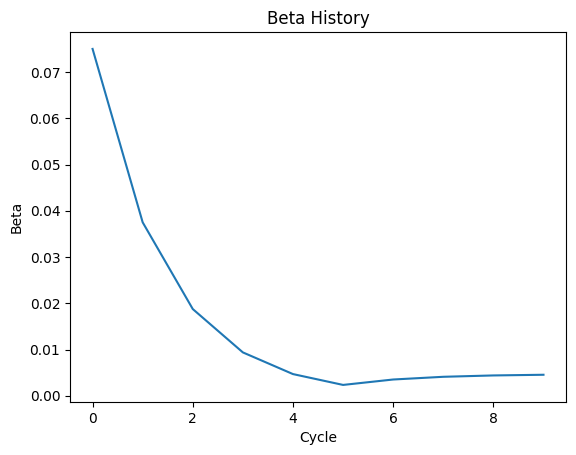

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:98.58|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 98.58%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)
Current beta: 0.005



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:98.58|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:40<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.05|ACC:98.58|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.58%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.016259765625
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)


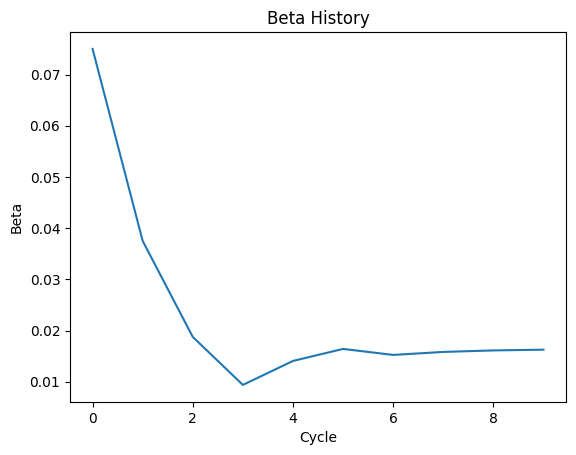


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.69|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 98.69%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)
Current beta: 0.01


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.69|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:39<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:0.08|ACC:98.69|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.69%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.015673828124999997
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)


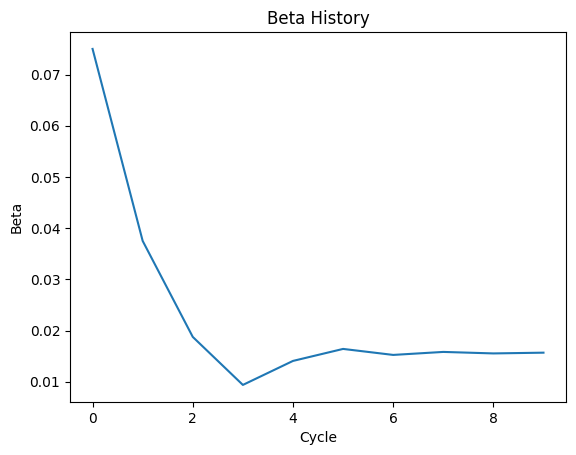

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.99|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 98.99%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)
Current beta: 0.015



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.99|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:39<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.99|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.99%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.014501953124999998
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)


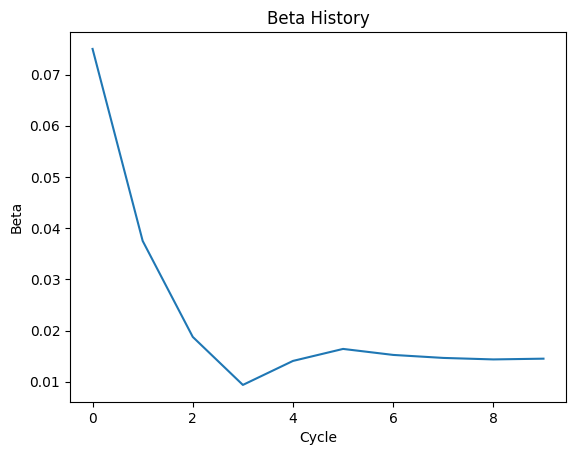


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:99.04|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:37<?, ?it/s]


Val accuracy: 99.04%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)
Current beta: 0.02


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:99.04|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:40<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:99.04|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 99.04%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.013623046875
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)


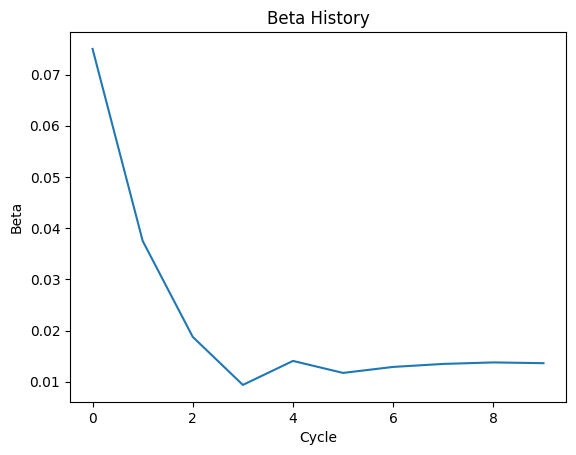


Val accuracy: 99.01%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 43.80% Structure: (39, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 348174 (51.87350716560509% pruned)
PARAMS: 10350 (55.078125% pruned)
Current beta: 0.025



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:99.04|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:40<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:99.01|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 99.01%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 49.41% Structure: (23, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 42.68% Structure: (38, 23) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.013330078124999999
FLOPS: 346311 (52.131021098726116% pruned)
PARAMS: 10143 (55.97656250000001% pruned)


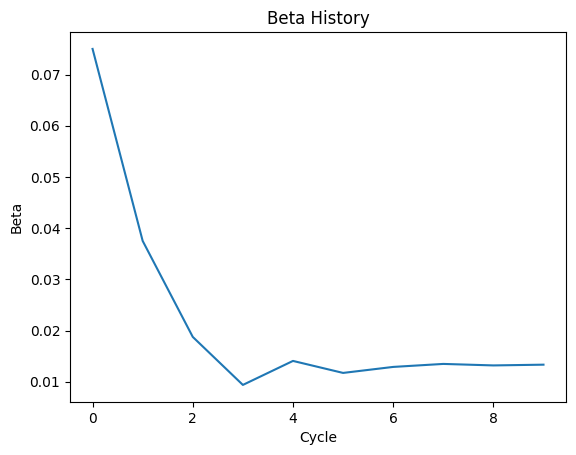

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:99.01|PR_F:51.87|PR_P:55.08:   0%|       | 0/1876 [00:37<?, ?it/s]


Val accuracy: 98.87%


In [14]:
cycles = 5
prune = 0.5
lr = 0.015
momentum = 0.9
weight_decay = 1e-3
savepath = '/content/drive/MyDrive/ECE570_AI/Project/group_channel_pruning_best_model.pth'
our_cnn = OurCNN()

loadpath_group = '/content/drive/MyDrive/ECE570_AI/Project/group_learning_best_model.pth'
state_dict = torch.load(loadpath_group)
filtered_state_dict = {k: v for k, v in state_dict[0].items() if k in our_cnn.state_dict()}

our_cnn = OurCNN()
our_cnn.load_state_dict(filtered_state_dict)
our_cnn.to(device)
# our_cnn.load_state_dict(filtered_state_dict, strict=False)



# #plot history
# plt.plot(beta_history)
# plt.xlabel('Cycle')
# plt.ylabel('Beta')
# plt.title('Beta History')
# plt.show()

print("="*80)
print("Starting pruning")
print("="*80)
result_dict = {}
values = np.arange(0, 0.03, 0.005)
# for beta in [0, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27]:
for beta in values:
    pruner = PruneWrapper(our_cnn,groups, 2)

    total_params = sum(p.numel() for p in our_cnn.parameters())
    # print(f'OurCNN has a total of {total_params} parameters')

    epoch_per_cycle = math.ceil(max_epoch / cycles)
    scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

    flops, params, beta_history = pruner.initialize(prune, beta=0.15)
    bestset = {'acc':0, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
    print("="*80)
    print(f"Current beta: {beta}")
    if(beta != 0):
      pruner.beta = beta
    bar = tqdm(total=len(train_loader) * max_epoch, ncols=120)
    for epoch in range(max_epoch):
        our_cnn.train()
        for step, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            gpuimg = images.to(device)
            labels = labels.to(device)

            outputs = our_cnn(gpuimg)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            pruner.after_step()
            # bar.set_description("[" + "OurCNN channel pruning" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # bar.update()

        scheduler.step()
        our_cnn.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = our_cnn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cpu() == labels).sum().item()
        acc = 100 * correct / total
        print()
        print(f"Val accuracy: {acc}%")
        our_cnn.train()

        if bestset['acc']<=acc:
            bestset = {'acc':acc, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
            torch.save([bestset['state_dict'], bestset['acc']], savepath)
            bar.set_description("[" + "OurCNN channel pruning, save" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # if(beta != 0):
            result_dict[beta] = [bestset['acc'], bestset['flops'], bestset['params'], pruner.beta]
            # else:
              # result_dict[pruner.beta] = [bestset['acc'], bestset['flops'], bestset['params']]

        # prune a small portion of channels for each cycle
        # to prevent over-fitting and to remove dead channels
        if (epoch<max_epoch-1) and ((epoch+1)%epoch_per_cycle==0):
            our_cnn.load_state_dict(bestset['state_dict'])
            flops, params, beta_history_new=pruner.initialize(bestset['flops']/100+0.001)
            optimizer = torch.optim.SGD(our_cnn.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

            plt.plot(beta_history_new)
            plt.xlabel('Cycle')
            plt.ylabel('Beta')
            plt.title('Beta History')
            plt.show()

bar.close()

{0.0: [98.58, 51.87350716560509, 55.078125, 0.004541015625], 0.005: [98.69, 51.87350716560509, 55.078125, 0.016259765625], 0.01: [98.99, 51.87350716560509, 55.078125, 0.015673828124999997], 0.015: [99.04, 51.87350716560509, 55.078125, 0.014501953124999998], 0.02: [99.04, 51.87350716560509, 55.078125, 0.02], 0.025: [99.01, 51.87350716560509, 55.078125, 0.025]}


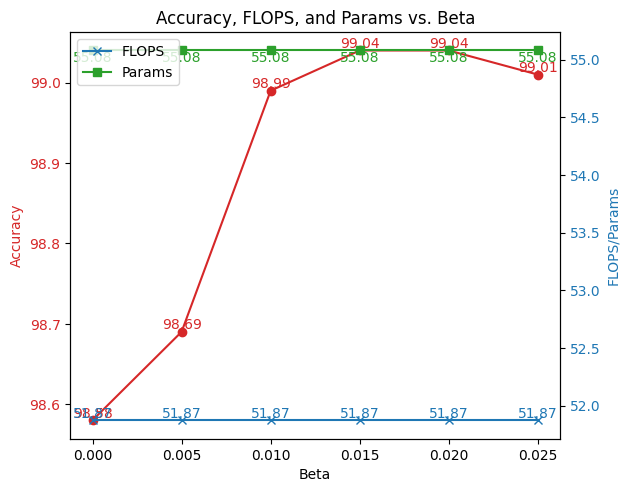

In [15]:
# #plot result_dict

# plt.plot(list(result_dict.keys()), [result_dict[key][0] for key in result_dict.keys()])
# plt.xlabel('Beta')
# plt.ylabel('Accuracy')
# plt.title('Accuracy vs Beta')
# plt.show()

# #plot flops from result_dict
# plt.plot(list(result_dict.keys()), [result_dict[key][1] for key in result_dict.keys()])
# plt.xlabel('Beta')
# plt.ylabel('FLOPS')
# plt.title('FLOPS vs Beta')
# plt.show()

# #plot params from result_dict
# plt.plot(list(result_dict.keys()), [result_dict[key][2] for key in result_dict.keys()])
# plt.xlabel('Beta')
# plt.ylabel('PARAMS')
# plt.title('PARAMS vs Beta')
# plt.show()

# #plot accuracy, flops and params in the same graph

result_dict = dict(sorted(result_dict.items()))
print(result_dict)
betas = list(result_dict.keys())
accuracies = [result_dict[key][0] for key in betas]
flops = [result_dict[key][1] for key in betas]
params = [result_dict[key][2] for key in betas]

fig, ax1 = plt.subplots()

# Accuracy
color = 'tab:red'
ax1.set_xlabel('Beta')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(betas, accuracies, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Add data labels for Accuracy
for x, y in zip(betas, accuracies):
    ax1.text(x, y, f'{y:.2f}', ha='center', va='bottom', color=color)

# FLOPS and Params
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('FLOPS/Params', color=color)
ax2.plot(betas, flops, color=color, marker='x', label='FLOPS')
ax2.plot(betas, params, color='tab:green', marker='s', label='Params')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for FLOPS and Params
for x, y in zip(betas, flops):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='bottom', color='tab:blue')
for x, y in zip(betas, params):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='top', color='tab:green')  # Adjusted va for clarity

fig.tight_layout()
plt.title('Accuracy, FLOPS, and Params vs. Beta')
plt.legend(loc='upper left')
plt.show()


From the generated plot, we can observe that beta value has an impact on the pruning process. A higher beta value will result in a higher accuracy but a less pruned model

Proposal 1: Alternate method to determine masking threshold. Some channels/filters might have a low L1-norm value but still contribute decently to the network's performance. A statistical approach can be taken to determine how far from the importance mean the data can be pruned. Beta value can be used to help determine the multiplier value.

Proposal 1.1: Use of mean and standard deviation to calculate the pruning threshold value instead of taking the rank.

In [16]:
from scipy.stats import norm

def percentile_to_std_dev(percentile):
    # Convert percentile (0 to 1) to standard deviations
    return norm.ppf(percentile)

print(percentile_to_std_dev(0.1))

-1.2815515655446004


In [17]:
def find_mask_std(layer):
    rate = 0.5
    layer.mask.fill_(1)
    importance = layer.weight.data**2

    # Calculate the importance score for each group of channels
    imp = torch.stack([((p.view(-1, 1, 1, 1)**2) * importance).sum(dim=(3, 2, 0)) for p in layer.prob], dim=0)
    imp = imp / (imp.sum(dim=1, keepdim=True) + 1e-12)

    # Calculate mean and standard deviation for each group of channels
    mean_imp = imp.mean(dim=1, keepdim=True)
    std_imp = imp.std(dim=1, keepdim=True)

    # Define a threshold based on mean and standard deviation
    # Here `self.beta` acts as the multiplier for standard deviation
    threshold = mean_imp - percentile_to_std_dev(rate) * std_imp

    # Create mask by comparing importance scores to threshold within each group
    mask = (layer.prob.unsqueeze(2) * (imp > threshold).float().unsqueeze(1)).sum(0)

    # print(f"mask: {mask}, threshold: {threshold}")

    # Copy the mask back to the layer, maintaining the original shape
    layer.mask.copy_(mask.view(mask.size(0), mask.size(1), 1, 1))


def find_mask_fp_std(layer):
    rate = 0.5
    # importance = torch.sum(torch.abs(layer.weight.data), dim=(1, 2, 3))
    # # Proposed improvement: Adaptive thresholding
    # importance_mean = torch.mean(importance)
    # importance_std = torch.std(importance)
    # multiplier = percentile_to_std_dev(rate)#1.0  # Adjust as needed
    # threshold = importance_mean - (multiplier * importance_std)

    # mask = importance > threshold
    # # layer.mask.copy_(mask.view(mask.size(0),mask.size(1),1,1))
    # view_shape = [mask.shape[0]] + [1] * (layer.weight.data.dim() - 1)
    # layer.mask.copy_(mask.view(*view_shape))
    importance = layer.weight.data**2

    # Calculate the importance score for each channel
    imp = importance.sum(dim=(3, 2, 1))
    imp = imp / (imp.sum() + 1e-12)

    # Calculate mean and standard deviation for the importance scores
    mean_imp = imp.mean()
    std_imp = imp.std()

    # Define a threshold based on mean and standard deviation
    # Here `self.beta` acts as the multiplier for standard deviation
    threshold = mean_imp - percentile_to_std_dev(rate) * std_imp

    # Create mask by comparing importance scores to the threshold
    mask = (imp > threshold).float().unsqueeze(1)

    # Apply the mask to the layer, retaining the original shape
    layer.mask.mul_(mask.view(mask.size(0), mask.size(1), 1, 1))




Starting pruning
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate


<ipython-input-18-e1399156b69c>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(loadpath_group)


[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)
Current beta: 0.0


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.47|ACC:34.35|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:16<?, ?it/s]


Val accuracy: 34.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.892919921875
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)


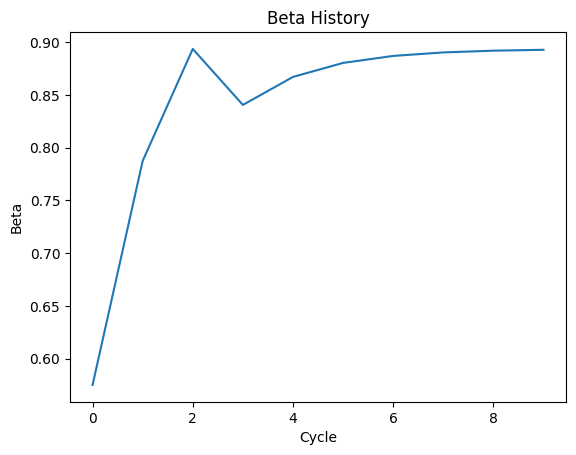

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.05|ACC:98.56|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 98.56%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)
Current beta: 0.005



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.05|ACC:98.56|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:40<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:98.56|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.56%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)


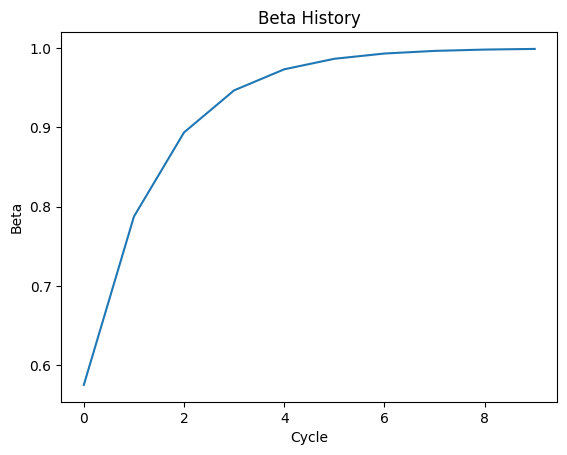


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.11|ACC:98.60|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:37<?, ?it/s]


Val accuracy: 98.6%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)
Current beta: 0.01


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.11|ACC:98.60|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:41<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.60|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.6%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)


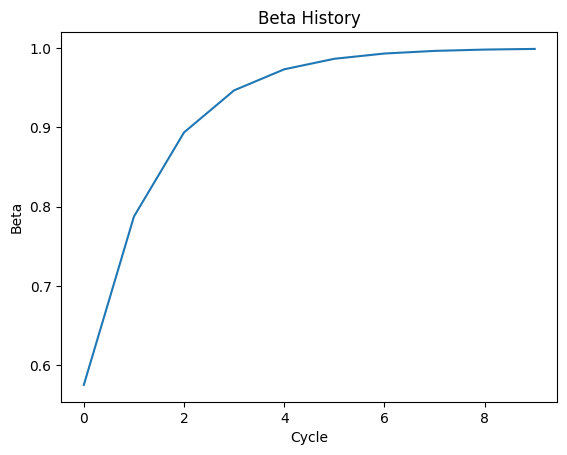


Val accuracy: 98.46%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)
Current beta: 0.015



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.60|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:40<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.46|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.46%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)


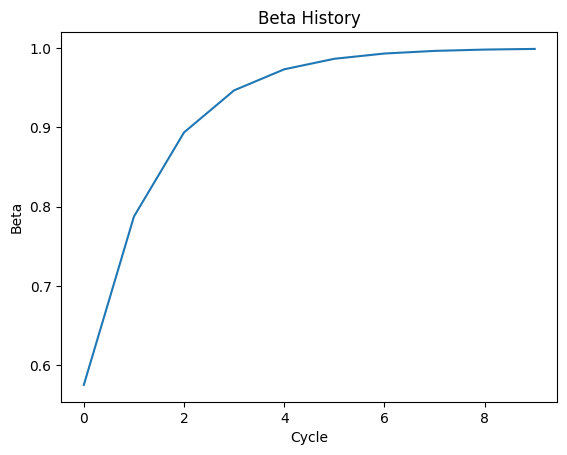


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.15|ACC:98.59|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:37<?, ?it/s]


Val accuracy: 98.59%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)
Current beta: 0.02


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.15|ACC:98.59|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:41<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:0.05|ACC:98.59|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.59%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)


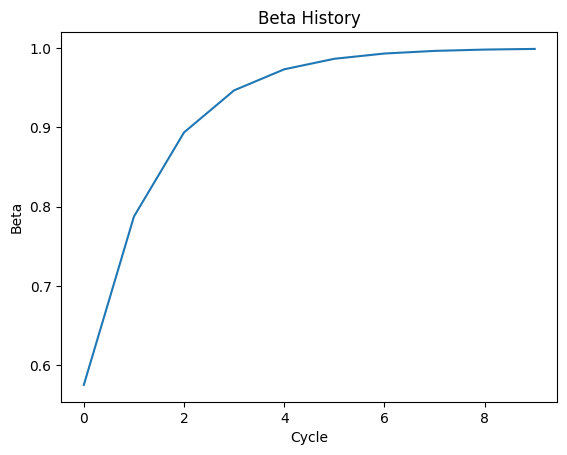


Val accuracy: 98.29%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)
Current beta: 0.025



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.05|ACC:98.59|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:40<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.29|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:16<?, ?it/s]


Val accuracy: 98.29%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 15.23% Structure: (13, 6) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 13.96% Structure: (22, 13) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 108108 (85.05672770700636% pruned)
PARAMS: 3276 (85.78125% pruned)


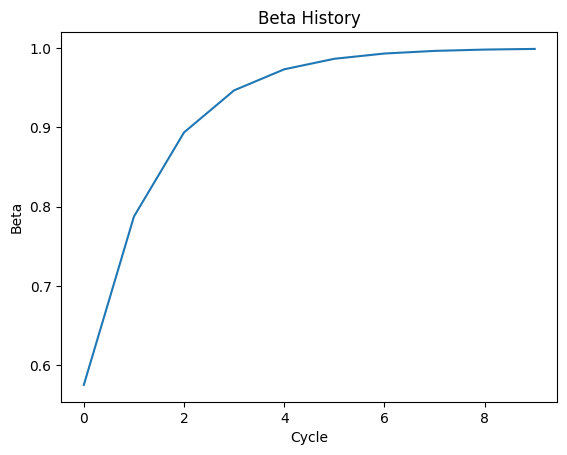


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:98.61|PR_F:85.06|PR_P:85.78:   0%|       | 0/1876 [00:37<?, ?it/s]


Val accuracy: 98.61%


In [18]:
cycles = 5
prune = 0.5
lr = 0.015
momentum = 0.9
weight_decay = 1e-3
savepath = '/content/drive/MyDrive/ECE570_AI/Project/group_channel_pruning_best_model.pth'
our_cnn = OurCNN()

loadpath_group = '/content/drive/MyDrive/ECE570_AI/Project/group_learning_best_model.pth'
state_dict = torch.load(loadpath_group)
filtered_state_dict = {k: v for k, v in state_dict[0].items() if k in our_cnn.state_dict()}

our_cnn = OurCNN()
our_cnn.load_state_dict(filtered_state_dict)
our_cnn.to(device)
# our_cnn.load_state_dict(filtered_state_dict, strict=False)



# #plot history
# plt.plot(beta_history)
# plt.xlabel('Cycle')
# plt.ylabel('Beta')
# plt.title('Beta History')
# plt.show()

print("="*80)
print("Starting pruning")
print("="*80)
result_dict = {}
values = np.arange(0, 0.03, 0.005)
# for beta in [0, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27]:
for beta in values:
    pruner = PruneWrapper(our_cnn,groups, 2)
    pruner.find_mask = find_mask_std
    pruner.find_mask_fp = find_mask_fp_std

    total_params = sum(p.numel() for p in our_cnn.parameters())
    # print(f'OurCNN has a total of {total_params} parameters')

    epoch_per_cycle = math.ceil(max_epoch / cycles)
    scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

    flops, params, beta_history = pruner.initialize(prune, beta=0.15)
    bestset = {'acc':0, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
    print("="*80)
    print(f"Current beta: {beta}")
    if(beta != 0):
      pruner.beta = beta
    bar = tqdm(total=len(train_loader) * max_epoch, ncols=120)
    for epoch in range(max_epoch):
        our_cnn.train()
        for step, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            gpuimg = images.to(device)
            labels = labels.to(device)

            outputs = our_cnn(gpuimg)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            pruner.after_step()
            # bar.set_description("[" + "OurCNN channel pruning" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # bar.update()

        scheduler.step()
        our_cnn.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = our_cnn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cpu() == labels).sum().item()
        acc = 100 * correct / total
        print()
        print(f"Val accuracy: {acc}%")
        our_cnn.train()

        if bestset['acc']<=acc:
            bestset = {'acc':acc, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
            torch.save([bestset['state_dict'], bestset['acc']], savepath)
            bar.set_description("[" + "OurCNN channel pruning, save" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # if(beta != 0):
            result_dict[beta] = [bestset['acc'], bestset['flops'], bestset['params'], pruner.beta]
            # else:
              # result_dict[pruner.beta] = [bestset['acc'], bestset['flops'], bestset['params']]

        # prune a small portion of channels for each cycle
        # to prevent over-fitting and to remove dead channels
        if (epoch<max_epoch-1) and ((epoch+1)%epoch_per_cycle==0):
            our_cnn.load_state_dict(bestset['state_dict'])
            flops, params, beta_history_new=pruner.initialize(bestset['flops']/100+0.001)
            optimizer = torch.optim.SGD(our_cnn.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

            plt.plot(beta_history_new)
            plt.xlabel('Cycle')
            plt.ylabel('Beta')
            plt.title('Beta History')
            plt.show()

bar.close()

       Accuracy      FLOPS    Params     Beta
0.000     98.56  85.056728  85.78125  0.89292
0.005     98.60  85.056728  85.78125  0.99917
0.010     98.60  85.056728  85.78125  0.01000
0.015     98.59  85.056728  85.78125  0.99917
0.020     98.59  85.056728  85.78125  0.02000
0.025     98.61  85.056728  85.78125  0.99917


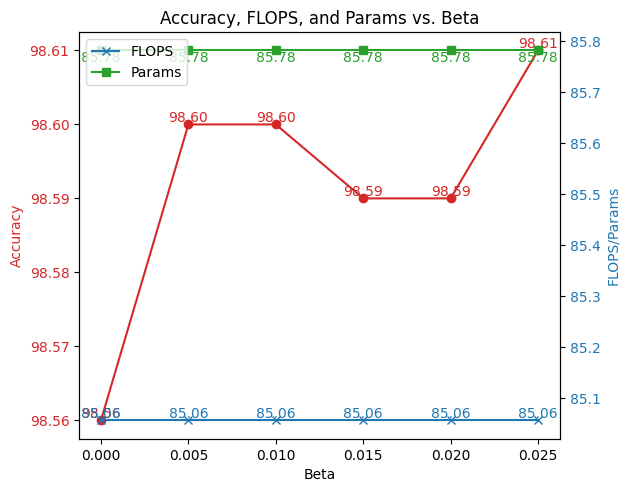

In [19]:
# pruning_rates = result_dict

df = pd.DataFrame.from_dict(result_dict, orient='index', columns=['Accuracy', 'FLOPS', 'Params', 'Beta'])
print(df)
betas = list(result_dict.keys())
accuracies = [result_dict[key][0] for key in betas]
flops = [result_dict[key][1] for key in betas]
params = [result_dict[key][2] for key in betas]

fig, ax1 = plt.subplots()

# Accuracy
color = 'tab:red'
ax1.set_xlabel('Beta')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(betas, accuracies, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Add data labels for Accuracy
for x, y in zip(betas, accuracies):
    ax1.text(x, y, f'{y:.2f}', ha='center', va='bottom', color=color)

# FLOPS and Params
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('FLOPS/Params', color=color)
ax2.plot(betas, flops, color=color, marker='x', label='FLOPS')
ax2.plot(betas, params, color='tab:green', marker='s', label='Params')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for FLOPS and Params
for x, y in zip(betas, flops):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='bottom', color='tab:blue')
for x, y in zip(betas, params):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='top', color='tab:green')  # Adjusted va for clarity

fig.tight_layout()
plt.title('Accuracy, FLOPS, and Params vs. Beta')
plt.legend(loc='upper left')
plt.show()


From the graph above, we can see that beta has minimal impact on the pruning and accuracy as the standard deviation method effectively by-passed the need of the beta value and uses the target pruning rate directly. This can save computation of the binary search for the ideal beta value, have a more aggressive pruning strategy, while maintaining high accuracy.

Proposal 1.2: The use of knee point detection to look for a knee point where the importance drops and pruning can be done.

In [20]:
def find_knee_point(values):
    # # Sort values for a clear curve shape
    # values_sorted, _ = values.sort()

    # # Identify the start and end points for line fitting
    # start, end = values_sorted[0], values_sorted[-1]

    # # Calculate the line equation between start and end points
    # line_vec = end - start
    # line_vec_norm = line_vec / line_vec.norm()

    # # Calculate distances from each point to the line
    # distances = torch.abs(torch.cross(line_vec.expand_as(values_sorted) - start, values_sorted - start, dim=0))

    # # Knee point is the point with the maximum distance from the line
    # knee_index = torch.argmax(distances)
    # threshold = values_sorted[knee_index]

    values_sorted, _ = torch.sort(values)

    # Calculate the difference between consecutive values
    diffs = values_sorted[1:] - values_sorted[:-1]

    # Find the index where the difference starts to decrease significantly
    # (i.e., the knee point)
    knee_index = torch.argmax(diffs)

    # Return the value at the knee point
    threshold = values_sorted[knee_index]
    # print(f"Threshold: {threshold}, values_sorted: {values_sorted}")

    return threshold


In [21]:
def find_mask_knee(layer):
    layer.mask.fill_(1)
    importance = layer.weight.data**2

    # Calculate the importance score for each group of channels
    imp = torch.stack([((p.view(-1, 1, 1, 1)**2) * importance).sum(dim=(3, 2, 0)) for p in layer.prob], dim=0)
    imp = imp / (imp.sum(dim=1, keepdim=True) + 1e-12)
    # print(f"whole imp: {imp}")

    # Apply knee point detection to find threshold for each group
    thresholds = torch.stack([find_knee_point(group_imp) for group_imp in imp])

    # Create mask by comparing importance scores to group-specific threshold
    mask = (layer.prob.unsqueeze(2) * (imp > thresholds.unsqueeze(1)).float().unsqueeze(1)).sum(0)
    # print(mask)

    # Copy the mask back to the layer, maintaining the original shape
    layer.mask.copy_(mask.view(mask.size(0), mask.size(1), 1, 1))
    # print(layer.mask)

def find_mask_fp_knee(layer):
    importance = layer.weight.data**2

    # Calculate the importance score for each channel
    imp = importance.sum(dim=(3, 2, 1))
    imp = imp / (imp.sum() + 1e-12)

    # Find the knee point threshold across all channels
    threshold = find_knee_point(imp)

    # Create mask by comparing importance scores to the threshold
    mask = (imp > threshold).float().unsqueeze(1)

    # Apply the mask to the layer, retaining the original shape
    layer.mask.mul_(mask.view(mask.size(0), mask.size(1), 1, 1))

<ipython-input-22-6b02caa7b141>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(loadpath_group)


Starting pruning
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)
Current beta: 0.0


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:16<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:33<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


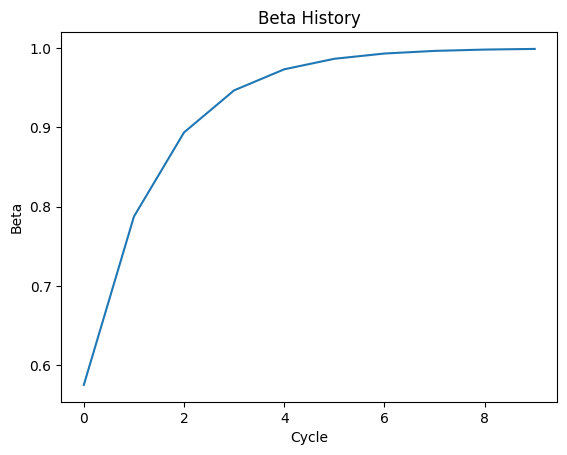

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:54<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:10<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


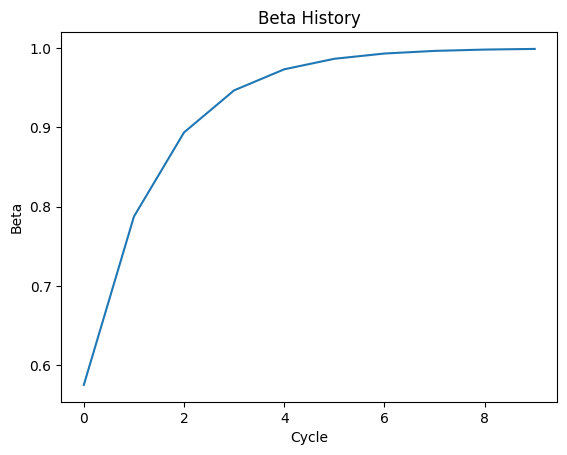

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:30<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:47<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


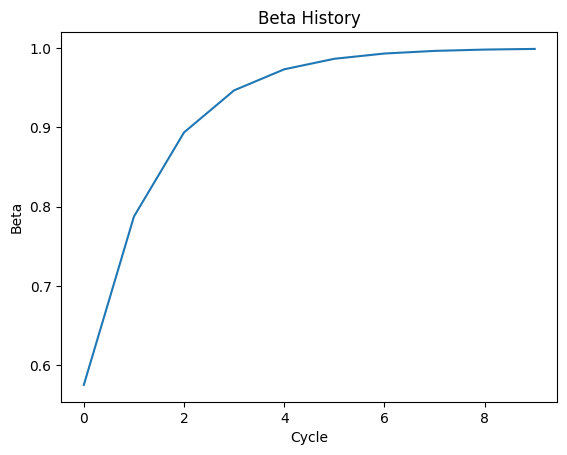

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:07<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:24<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


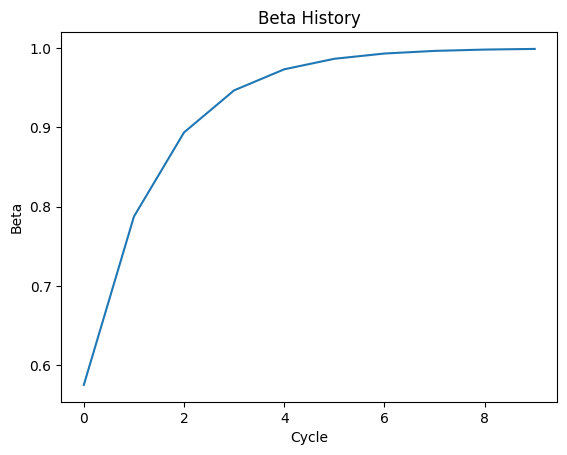

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:45<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:01<?, ?it/s]


Val accuracy: 11.35%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)
Current beta: 0.005



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:04<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:17<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:34<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


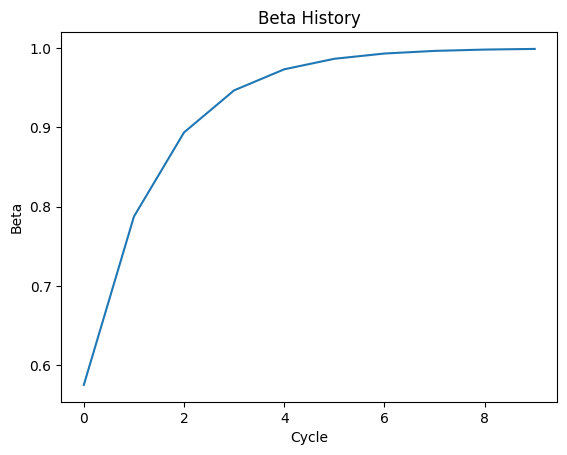


Val accuracy: 10.28%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:11<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


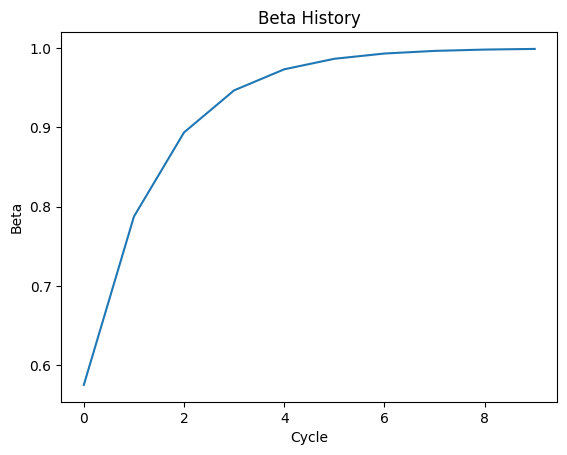


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:31<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:48<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


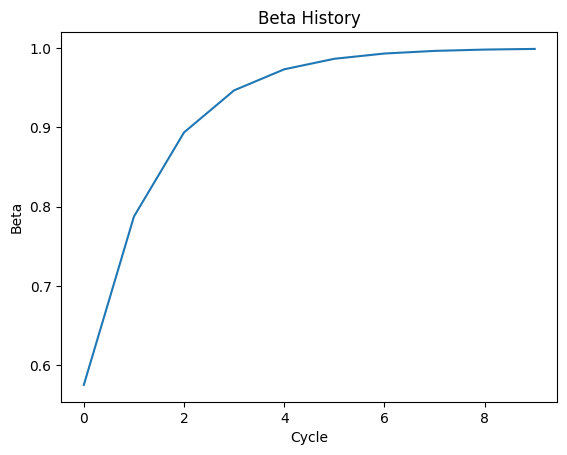


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:09<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:25<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


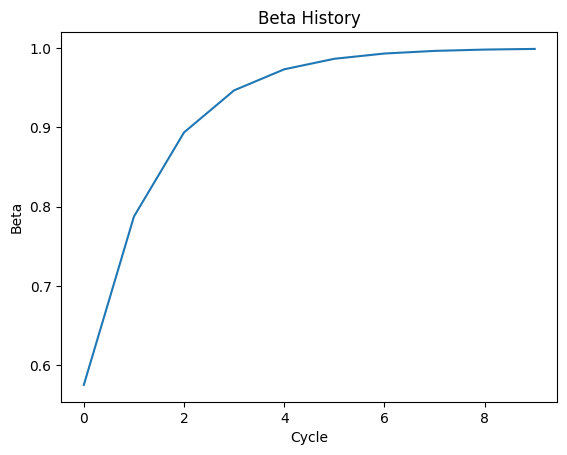


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:46<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:03<?, ?it/s]


Val accuracy: 11.35%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)
Current beta: 0.01


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:06<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:16<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:33<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


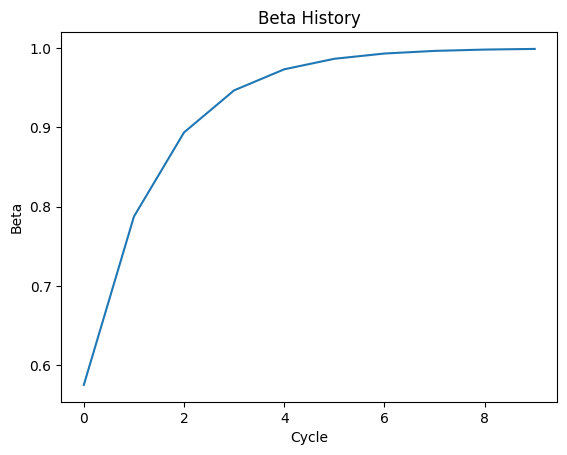

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:53<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.28|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:10<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


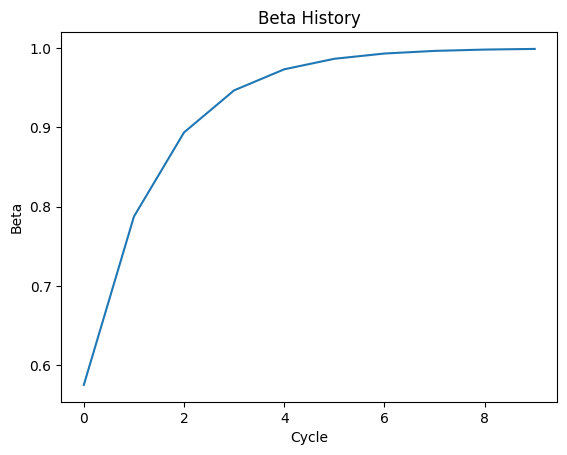

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:31<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:47<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


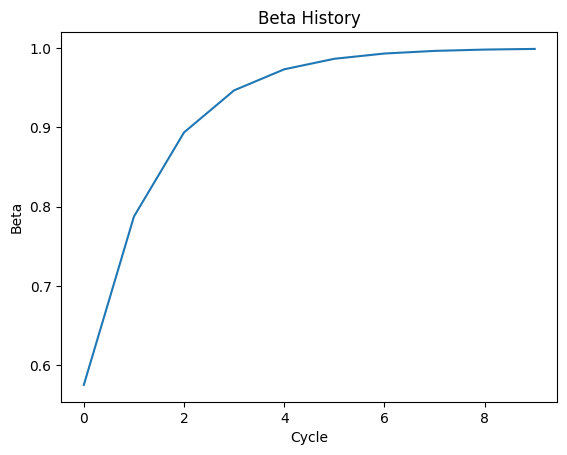

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:07<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:25<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


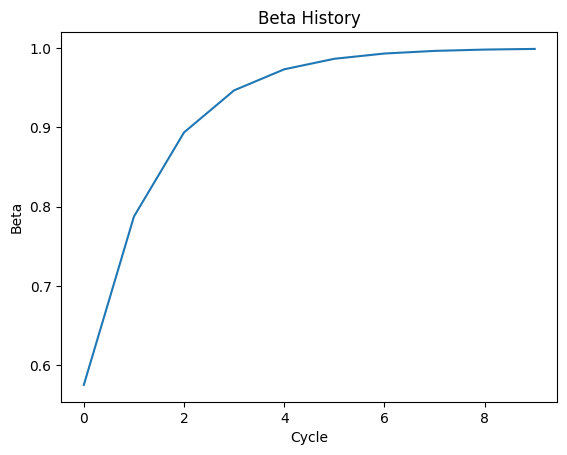

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:45<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:02<?, ?it/s]


Val accuracy: 11.35%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)
Current beta: 0.015



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:06<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:16<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:33<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


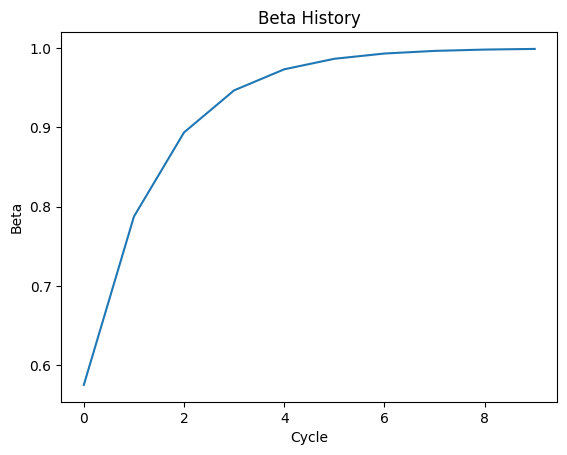


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:54<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:11<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


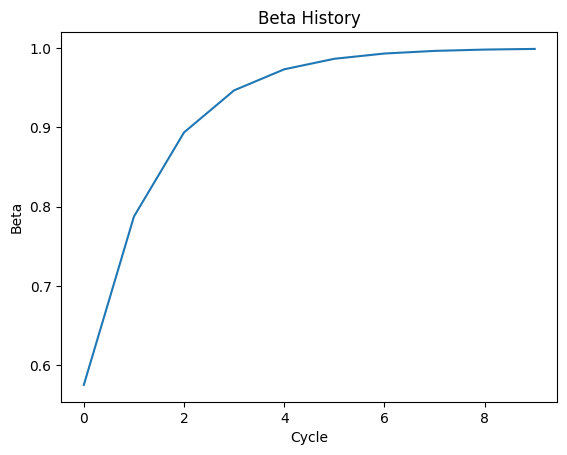


Val accuracy: 10.28%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:49<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


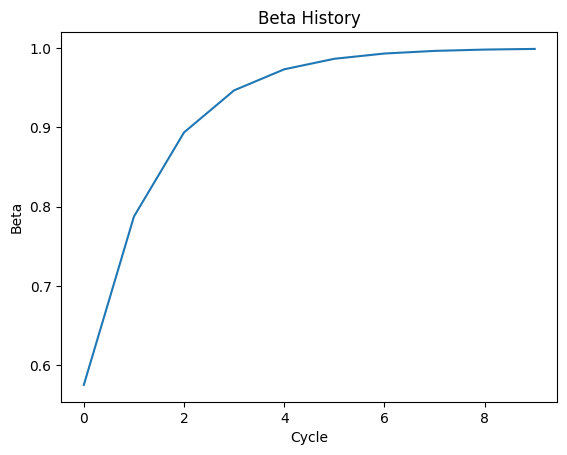


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:09<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:25<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


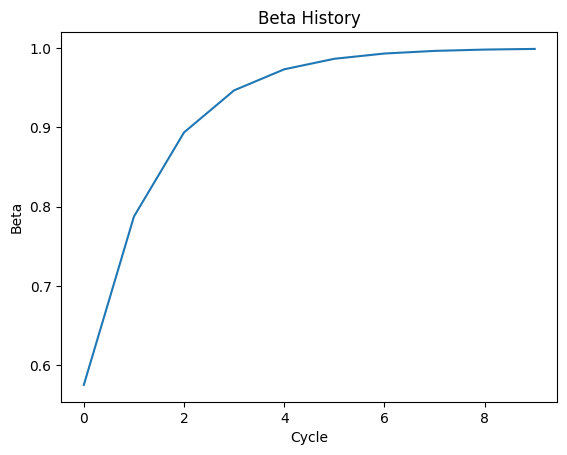


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:46<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:03<?, ?it/s]


Val accuracy: 11.35%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)
Current beta: 0.02


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:06<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:17<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:34<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


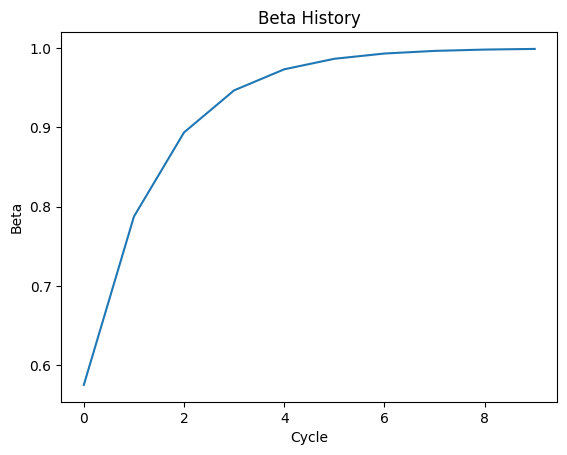

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:53<?, ?it/s]


Val accuracy: 11.35%

Val accuracy: 10.28%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


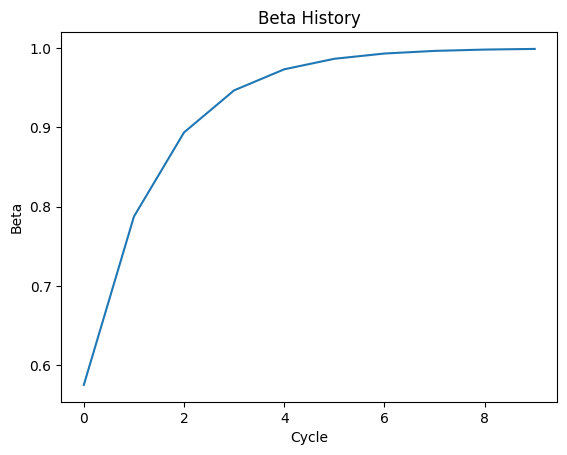

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:30<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:47<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


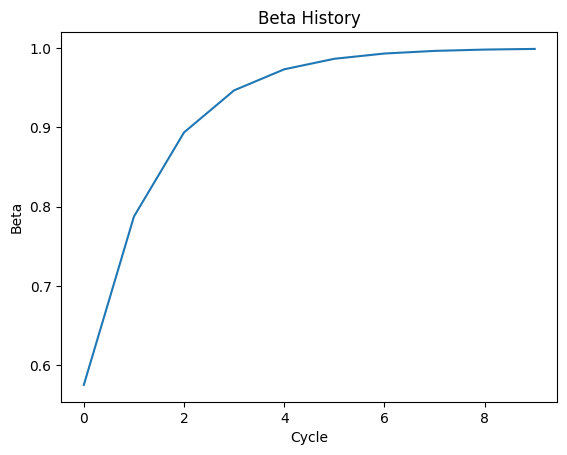

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:08<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.28|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:24<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


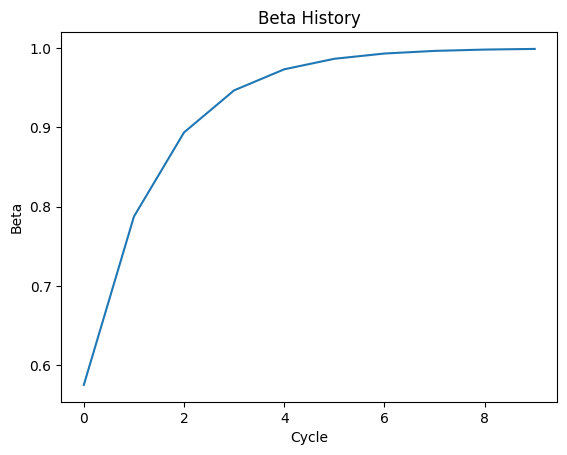

[OurCNN channel pruning, save]LR:0.0075|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:44<?, ?it/s]


Val accuracy: 11.35%


[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:01<?, ?it/s]


Val accuracy: 11.35%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.000146484375
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)
Current beta: 0.025



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.29|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:04<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:16<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:32<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


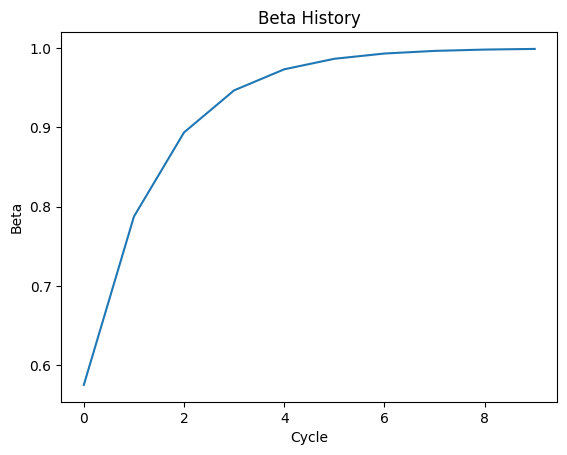


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [00:53<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.31|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:09<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


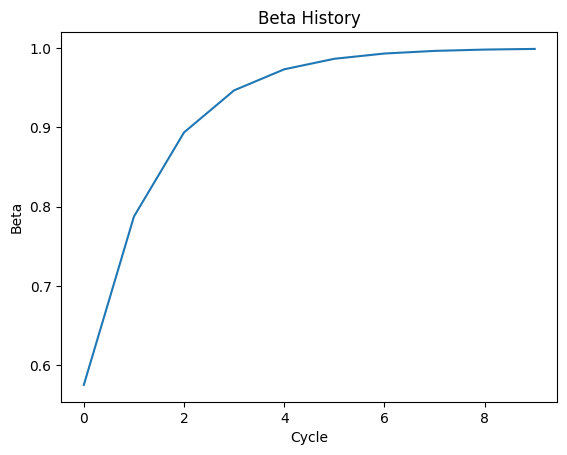


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:30<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [01:47<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


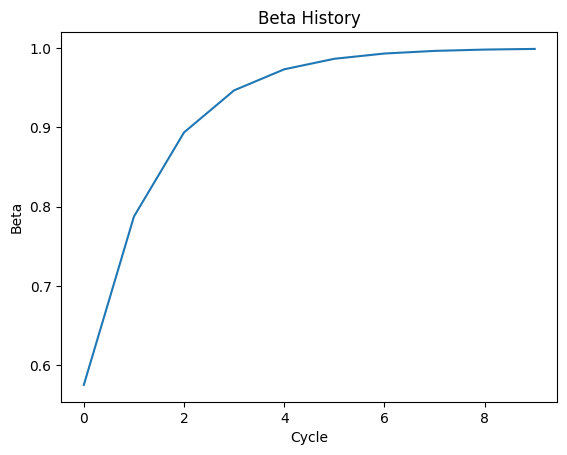


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:06<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:23<?, ?it/s]


Val accuracy: 11.35%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 0.00% Structure: (0, 0) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.999169921875
FLOPS: 0 (100.0% pruned)
PARAMS: 0 (100.0% pruned)


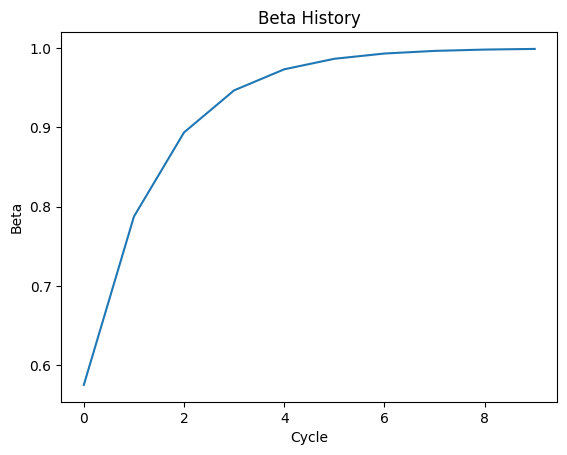


[OurCNN channel pruning, save]LR:0.0075|LOSS:2.32|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [02:43<?, ?it/s]


Val accuracy: 11.35%



[OurCNN channel pruning, save]LR:0.0000|LOSS:2.30|ACC:11.35|PR_F:100.00|PR_P:100.00:   0%|     | 0/9380 [03:00<?, ?it/s]


Val accuracy: 11.35%


In [22]:
cycles = 5
prune = 0.5
lr = 0.015
momentum = 0.9
weight_decay = 1e-3
max_epoch = 10
savepath = '/content/drive/MyDrive/ECE570_AI/Project/group_channel_pruning_best_model.pth'
our_cnn = OurCNN()

loadpath_group = '/content/drive/MyDrive/ECE570_AI/Project/group_learning_best_model.pth'
state_dict = torch.load(loadpath_group)
filtered_state_dict = {k: v for k, v in state_dict[0].items() if k in our_cnn.state_dict()}

our_cnn = OurCNN()
our_cnn.load_state_dict(filtered_state_dict)
our_cnn.to(device)
# our_cnn.load_state_dict(filtered_state_dict, strict=False)



# #plot history
# plt.plot(beta_history)
# plt.xlabel('Cycle')
# plt.ylabel('Beta')
# plt.title('Beta History')
# plt.show()

print("="*80)
print("Starting pruning")
print("="*80)
result_dict_knee = {}
values = np.arange(0, 0.03, 0.005)
# for beta in [0, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27]:
for beta in values:
    pruner = PruneWrapper(our_cnn,groups, 2)
    pruner.find_mask = find_mask_knee
    pruner.find_mask_fp = find_mask_fp_knee

    total_params = sum(p.numel() for p in our_cnn.parameters())
    # print(f'OurCNN has a total of {total_params} parameters')

    epoch_per_cycle = math.ceil(max_epoch / cycles)
    scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

    flops, params, beta_history = pruner.initialize(prune, beta=0.15)
    bestset = {'acc':0, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
    print("="*80)
    print(f"Current beta: {beta}")
    if(beta != 0):
      pruner.beta = beta
    bar = tqdm(total=len(train_loader) * max_epoch, ncols=120)
    for epoch in range(max_epoch):
        our_cnn.train()
        for step, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            gpuimg = images.to(device)
            labels = labels.to(device)

            outputs = our_cnn(gpuimg)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            pruner.after_step()
            # bar.set_description("[" + "OurCNN channel pruning" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # bar.update()

        scheduler.step()
        our_cnn.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = our_cnn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cpu() == labels).sum().item()
        acc = 100 * correct / total
        print()
        print(f"Val accuracy: {acc}%")
        our_cnn.train()

        if bestset['acc']<=acc:
            bestset = {'acc':acc, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
            torch.save([bestset['state_dict'], bestset['acc']], savepath)
            bar.set_description("[" + "OurCNN channel pruning, save" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # if(beta != 0):
            result_dict_knee[beta] = [bestset['acc'], bestset['flops'], bestset['params'], pruner.beta]
            # else:
              # result_dict[pruner.beta] = [bestset['acc'], bestset['flops'], bestset['params']]

        # prune a small portion of channels for each cycle
        # to prevent over-fitting and to remove dead channels
        if (epoch<max_epoch-1) and ((epoch+1)%epoch_per_cycle==0):
            our_cnn.load_state_dict(bestset['state_dict'])
            flops, params, beta_history_new=pruner.initialize(bestset['flops']/100+0.001)
            optimizer = torch.optim.SGD(our_cnn.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

            plt.plot(beta_history_new)
            plt.xlabel('Cycle')
            plt.ylabel('Beta')
            plt.title('Beta History')
            plt.show()

bar.close()

       Accuracy  FLOPS  Params     Beta
0.000     11.35  100.0   100.0  0.99917
0.005     11.35  100.0   100.0  0.99917
0.010     11.35  100.0   100.0  0.99917
0.015     11.35  100.0   100.0  0.99917
0.020     11.35  100.0   100.0  0.99917
0.025     11.35  100.0   100.0  0.99917


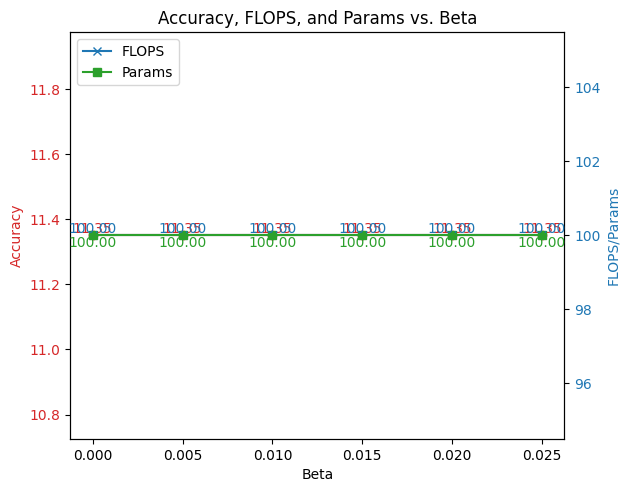

In [23]:
df = pd.DataFrame.from_dict(result_dict_knee, orient='index', columns=['Accuracy', 'FLOPS', 'Params', 'Beta'])
print(df)
betas = list(result_dict_knee.keys())
accuracies = [result_dict_knee[key][0] for key in betas]
flops = [result_dict_knee[key][1] for key in betas]
params = [result_dict_knee[key][2] for key in betas]

fig, ax1 = plt.subplots()

# Accuracy
color = 'tab:red'
ax1.set_xlabel('Beta')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(betas, accuracies, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Add data labels for Accuracy
for x, y in zip(betas, accuracies):
    ax1.text(x, y, f'{y:.2f}', ha='center', va='bottom', color=color)

# FLOPS and Params
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('FLOPS/Params', color=color)
ax2.plot(betas, flops, color=color, marker='x', label='FLOPS')
ax2.plot(betas, params, color='tab:green', marker='s', label='Params')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for FLOPS and Params
for x, y in zip(betas, flops):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='bottom', color='tab:blue')
for x, y in zip(betas, params):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='top', color='tab:green')  # Adjusted va for clarity

fig.tight_layout()
plt.title('Accuracy, FLOPS, and Params vs. Beta')
plt.legend(loc='upper left')
plt.show()

If we look at the imp tensor, most groups have 0 importance value. Technically, pruning them should not affect the final accuracy. However, using knee point method might over prune the model. I suspect that some weights with low importance but is closer to 0 than the other non-zero group importance will get pruned by this method. This method can be overly aggresive and can impact the accuracy of the model.

Proposal 2: Calculate Beta value for each layer.

In [24]:
class PruneWrapper(nn.Module):
    def __init__(self, model, n_groups=None, fp_every_nth_conv=None, fp_layer_indices=None, rank=0):
        super(PruneWrapper, self).__init__()
        self.rank = rank
        self.print("Initializing...")
        self.model = model
        self.layers = []
        self.fp_layers = []
        if fp_layer_indices is not None:
            fp_every_nth_conv = 2**32
        else:
            fp_layer_indices = []
            if fp_every_nth_conv is None:
                self.print('Please provide one of fp_every_nth_conv and fp_layer_indices.')
                self.print("If you don't want filter pruning, please set fp_every_nth_conv=-1 or fp_layer_indices=[]")
                raise ValueError
            elif fp_every_nth_conv == -1:
                fp_every_nth_conv = 2**32
        self.p_biases = []
        exclude = ['downsample']
        self.beta = 0

        l = -1
        self.print("Finding layers to be pruned")
        self.print("="*80)
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d) and all(e not in name for e in exclude):
                if l==-1:
                    l+=1
                    continue
                layer.register_buffer('group', torch.zeros(n_groups, layer.weight.size(0), device=layer.weight.device))
                layer.register_buffer('mask', torch.ones(layer.weight.size(0), layer.weight.size(1), 1, 1, device=layer.weight.device))
                self.layers.append(layer)
                w_dim = layer.weight.size()
                self.print(f"[{l}] {name}: {w_dim[0]} filters, {w_dim[1]} channels, {w_dim[2]}x{w_dim[3]} kernels")
                if ((l+1)%fp_every_nth_conv==0) or (l in fp_layer_indices):
                    self.fp_layers.append(layer)
                l+=1

        self.n_groups = n_groups

        hook = []
        for layer in self.layers:
            hook.append(Hook(layer))
        self.model.eval()
        with torch.no_grad():
            self.model(torch.randn(1,1,28,28, device=layer.weight.device))
        self.model.train()
        for h in hook:
            h.close()

    @torch.no_grad()
    def set_arch_hard(self, layer):
        index = layer.group.max(dim=0, keepdim=True)[1]
        layer.prob = torch.zeros_like(layer.group).scatter_(0, index, 1.0)

    @torch.no_grad()
    def find_mask(self, layer, beta): #added beta
        layer.mask.fill_(1)
        importance = layer.weight.data**2

        imp = torch.stack([((p.view(-1,1,1,1)**2)*importance).sum(dim=(3,2,0)) for p in layer.prob],dim=0)
        imp = imp/(imp.sum(dim=1,keepdim=True)+1e-12)
        rank = imp.sort(dim=1)[0]
        csoi = rank.cumsum(dim=1)
        count = (csoi<beta).long().sum(dim=1) #use beta instead of self.beta
        th = rank[torch.arange(rank.size(0)), count-1].unsqueeze(1)
        mask = (layer.prob.unsqueeze(2) * (imp > th).float().unsqueeze(1)).sum(0)

        layer.mask.copy_(mask.view(mask.size(0),mask.size(1),1,1))
        # print(f"layer info: {layer}, layer beta: {beta}, mask: {mask}")

    @torch.no_grad()
    def find_mask_fp(self, layer, beta): #added beta
        importance = layer.weight.data**2

        imp = importance.sum(dim=(3,2,1))
        imp = imp/(imp.sum()+1e-12)
        rank = imp.sort(dim=0)[0]
        csoi = rank.cumsum(dim=0)
        count = (csoi<beta).long().sum(dim=0)#use beta instead of layer beta
        th = rank[count-1]
        mask = (imp > th).float().unsqueeze(1)

        layer.mask.mul_(mask.view(mask.size(0),mask.size(1),1,1))

    @torch.no_grad()
    def apply_mask(self, layer):
        layer.weight.mul_(layer.mask)

    @torch.no_grad()
    def residual_bn_proc(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.bias.mul_((m.weight.abs()>0).float())


    def apply(self, func, inputs):
        return list(map(func, inputs))

    def print(self, *args):
        if self.rank==0:
            print(*args)

    def initialize(self, rate, n_iter=10, beta=0.15):
        self.print("="*80)
        self.print("Finding pruning settings to achieve the target pruning rate")
        self.print("="*80)
        self.apply(self.set_arch_hard, self.layers)
        checkpoints = copy.deepcopy(self.model.state_dict())
        # self.beta = beta#0.15
        # lower, upper = 0, 1.
        self.betas = {layer: beta for layer in self.layers}  # starting beta value of 0.15 for each layer
        lower_bounds = {layer: 0.0 for layer in self.layers}
        upper_bounds = {layer: 1.0 for layer in self.layers}
        #new change
        beta_history = {layer: [] for layer in self.layers}
        for _ in range(n_iter):
            pflops, pparams = self.prune()
            # if pflops>rate*100:
            #     temp = self.beta
            #     self.beta = (self.beta+lower)/2
            #     beta_history.append(self.beta)
            #     upper = temp
            # else:
            #     temp = self.beta
            #     self.beta = (self.beta+upper)/2
            #     beta_history.append(self.beta)
            #     lower = temp
            for layer in self.layers:
                layer_flops, layer_params = self.layer_summary(layer)  # get current layer's pruning results

                # Adjust beta per layer based on the pruning rate
                if layer_flops > rate * 100:  # if over-pruned for this layer
                    temp = self.betas[layer]
                    self.betas[layer] = (self.betas[layer] + lower_bounds[layer]) / 2
                    beta_history[layer].append(self.betas[layer])
                    upper_bounds[layer] = temp
                else:  # if under-pruned for this layer
                    temp = self.betas[layer]
                    self.betas[layer] = (self.betas[layer] + upper_bounds[layer]) / 2
                    beta_history[layer].append(self.betas[layer])
                    lower_bounds[layer] = temp
            self.model.load_state_dict(checkpoints)
        pflops, pparams = self.prune(True)
        return pflops, pparams, beta_history

    def prune(self, verbose=False):
        # self.apply(self.find_mask, self.layers)
        # Apply find_mask and find_mask_fp using per-layer beta values
        # for layer in self.layers:
        #     self.apply(lambda layer: self.find_mask(layer, beta=self.betas[layer]), self.layers)

        # self.apply(self.find_mask_fp, self.fp_layers)
        for layer in self.layers:
            self.find_mask(layer, self.betas[layer])
        for layer in self.fp_layers:
            self.find_mask_fp(layer, self.betas[layer])
        self.apply(self.apply_mask, self.layers)
        for _ in range(125):
            out = self.model(torch.randn(80, 1, 28, 28).cuda())
            F.cross_entropy(out, torch.randint(0, out.size(1), (80,)).cuda()).backward()

        # remove dead filters by tracking zero gradients
        with torch.no_grad():
            for m in self.model.modules():
                if isinstance(m, nn.Conv2d):
                    m.weight.mul_((m.weight.grad.abs().sum(dim=(3,2,1), keepdim=True)>0).float())
                    m.weight.mul_((m.weight.grad.abs().sum(dim=(3,2,0), keepdim=True)>0).float())
                    if hasattr(m, 'mask'):
                        m.mask.mul_((m.weight.grad.abs().sum(dim=(3,2,1), keepdim=True)>0).float())
                        m.mask.mul_((m.weight.grad.abs().sum(dim=(3,2,0), keepdim=True)>0).float())
                elif isinstance(m, nn.BatchNorm2d):
                    m.weight.mul_((m.weight.grad.abs()>0).float())
                    m.bias.mul_((m.weight.grad.abs()>0).float())

            pflops, pparams=self.summary(verbose)
        self.model.zero_grad(True)

        return pflops, pparams

    def summary(self, verbose=False, init=False):
        if init:
            self.apply(self.set_arch_hard, self.layers)
        remaining_flops = 0
        remaining_params = 0
        total_flops = 0
        total_params = 0
        for n, layer in enumerate(self.layers):
            kernels = (layer.weight.abs().sum(dim=(3,2))>0).float()
            remaining=torch.mm(layer.prob,kernels)
            r_ch = (remaining>0).float().sum(dim=1)
            r_f = (remaining.sum(1)/(r_ch+1e-8)).round()
            remaining_flops += layer.flops*kernels.sum().item()/kernels.numel()
            remaining_params += layer.weight.numel()*kernels.sum().item()/kernels.numel()
            total_flops += layer.flops
            total_params += layer.weight.numel()
            if verbose:
                self.print("[%d] FLOPS: %2.2f%%" % (n, 100*kernels.sum().item()/kernels.numel()), "Structure:",*list(zip(r_f.long().tolist(), r_ch.long().tolist())))
        pflops = 100*(1-remaining_flops/total_flops)
        pparams = 100*(1-remaining_params/total_params)
        if verbose:
            self.print("="*80)
            self.print("Summary")
            self.print(f"Beta: {self.beta}")
            self.print(f"FLOPS: {int(remaining_flops)} ({pflops}% pruned)")
            self.print(f"PARAMS: {int(remaining_params)} ({pparams}% pruned)")
            self.print("="*80)
        return pflops, pparams

    def layer_summary(self, layer, verbose=False, init=False):#newly added for layer specific data
        if init:
            self.apply(self.set_arch_hard, self.layers)
        remaining_flops = 0
        remaining_params = 0
        total_flops = 0
        total_params = 0
        kernels = (layer.weight.abs().sum(dim=(3,2))>0).float()
        remaining=torch.mm(layer.prob,kernels)
        r_ch = (remaining>0).float().sum(dim=1)
        r_f = (remaining.sum(1)/(r_ch+1e-8)).round()
        remaining_flops += layer.flops*kernels.sum().item()/kernels.numel()
        remaining_params += layer.weight.numel()*kernels.sum().item()/kernels.numel()
        total_flops += layer.flops
        total_params += layer.weight.numel()
        if verbose:
            self.print("[%d] FLOPS: %2.2f%%" % (n, 100*kernels.sum().item()/kernels.numel()), "Structure:",*list(zip(r_f.long().tolist(), r_ch.long().tolist())))
        pflops = 100*(1-remaining_flops/total_flops)
        pparams = 100*(1-remaining_params/total_params)
        if verbose:
            self.print("="*80)
            self.print("Summary")
            self.print(f"Beta: {self.betas[layer]}")
            self.print(f"FLOPS: {int(remaining_flops)} ({pflops}% pruned)")
            self.print(f"PARAMS: {int(remaining_params)} ({pparams}% pruned)")
            self.print("="*80)
        return pflops, pparams

    def after_step(self):
        self.apply(self.apply_mask, self.layers)
        self.residual_bn_proc()

    def forward(self, x):
        return self.model(x)

<ipython-input-25-d6cca05136a9>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(loadpath_group)


Starting pruning
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
Current beta: 0.0


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.17|ACC:95.02|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:16<?, ?it/s]


Val accuracy: 95.02%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
beta_history_new: {Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.028124999999999997, 0.032812499999999994, 0.03515625, 0.036328125, 0.0369140625, 0.037207031249999994, 0.037353515625], Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.009375, 0.0046875, 0.00234375, 0.001171875, 0.0005859375, 0.00029296875, 0.000146484375]}


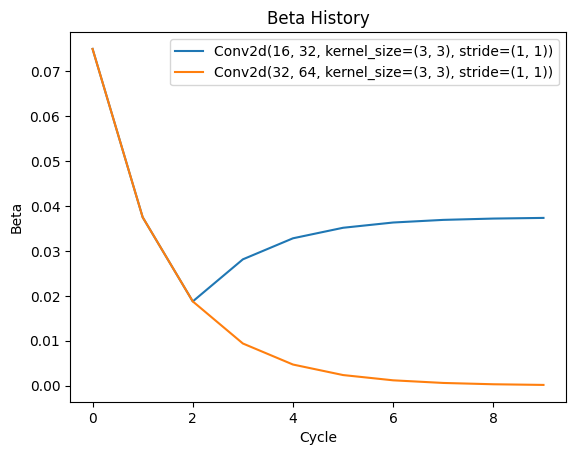

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.04|ACC:98.74|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 98.74%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
Current beta: 0.005



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.04|ACC:98.74|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:39<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.74|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.74%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.005
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
beta_history_new: {Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.028124999999999997, 0.032812499999999994, 0.03515625, 0.036328125, 0.0369140625, 0.037207031249999994, 0.037353515625], Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.009375, 0.0046875, 0.00234375, 0.001171875, 0.0005859375, 0.00029296875, 0.000146484375]}


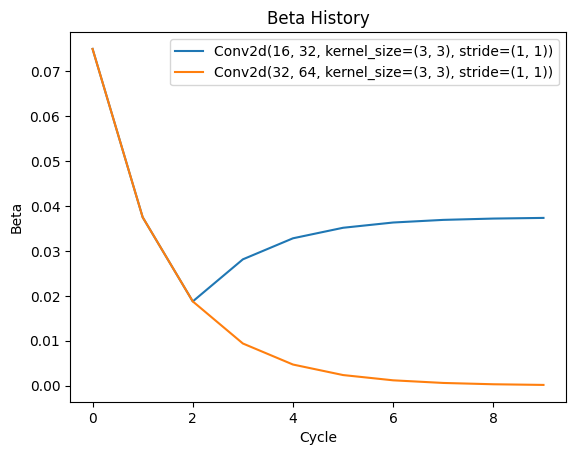


Val accuracy: 98.72%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
Current beta: 0.01


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:98.74|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:39<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:0.08|ACC:98.72|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.72%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.01
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
beta_history_new: {Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.028124999999999997, 0.032812499999999994, 0.03515625, 0.036328125, 0.0369140625, 0.037207031249999994, 0.037353515625], Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.009375, 0.0046875, 0.00234375, 0.001171875, 0.0005859375, 0.00029296875, 0.000146484375]}


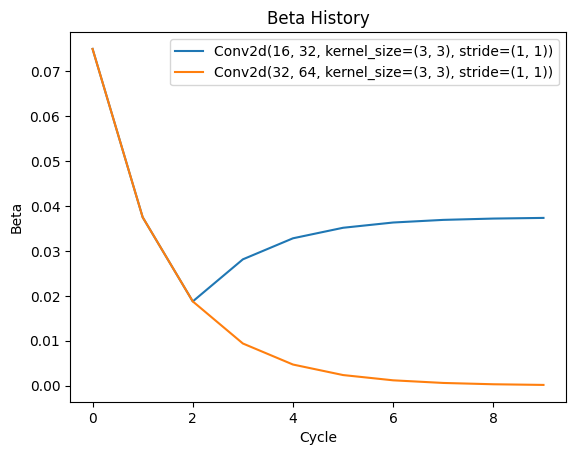

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:99.00|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:37<?, ?it/s]


Val accuracy: 99.0%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
Current beta: 0.015



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:99.00|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:40<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:99.00|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 99.0%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.015
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
beta_history_new: {Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.028124999999999997, 0.032812499999999994, 0.03515625, 0.036328125, 0.0369140625, 0.037207031249999994, 0.037353515625], Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.009375, 0.0046875, 0.00234375, 0.001171875, 0.0005859375, 0.00029296875, 0.000146484375]}


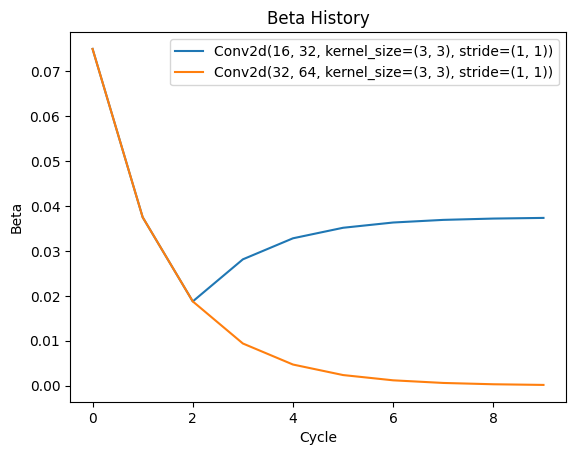


Val accuracy: 98.73%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
Current beta: 0.02


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.02|ACC:99.00|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:40<?, ?it/s]
[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.73|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:17<?, ?it/s]


Val accuracy: 98.73%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.02
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
beta_history_new: {Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.028124999999999997, 0.032812499999999994, 0.03515625, 0.036328125, 0.0369140625, 0.037207031249999994, 0.037353515625], Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.009375, 0.0046875, 0.00234375, 0.001171875, 0.0005859375, 0.00029296875, 0.000146484375]}


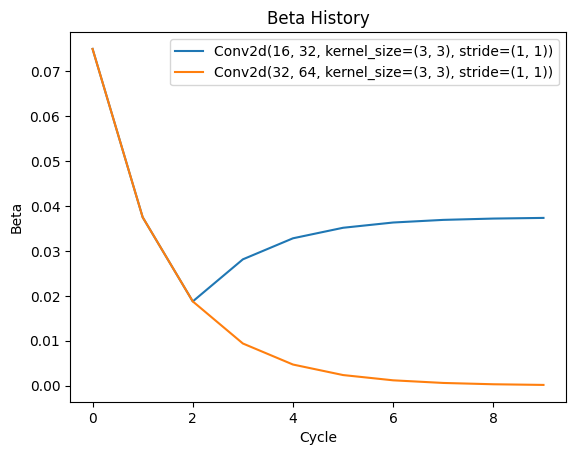

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.92|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 98.92%
Initializing...
Finding layers to be pruned
[0] l2: 32 filters, 16 channels, 3x3 kernels
[1] l3: 64 filters, 32 channels, 3x3 kernels
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
Current beta: 0.025



[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.92|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:39<?, ?it/s]

[OurCNN channel pruning, save]LR:0.0000|LOSS:0.00|ACC:98.92|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:16<?, ?it/s]


Val accuracy: 98.92%
Finding pruning settings to achieve the target pruning rate
[0] FLOPS: 51.56% Structure: (24, 11) (0, 0) (0, 0) (0, 0)
[1] FLOPS: 46.88% Structure: (40, 24) (0, 0) (0, 0) (0, 0)
Summary
Beta: 0.025
FLOPS: 365256 (49.512340764331206% pruned)
PARAMS: 11016 (52.1875% pruned)
beta_history_new: {Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.028124999999999997, 0.032812499999999994, 0.03515625, 0.036328125, 0.0369140625, 0.037207031249999994, 0.037353515625], Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1)): [0.075, 0.0375, 0.01875, 0.009375, 0.0046875, 0.00234375, 0.001171875, 0.0005859375, 0.00029296875, 0.000146484375]}


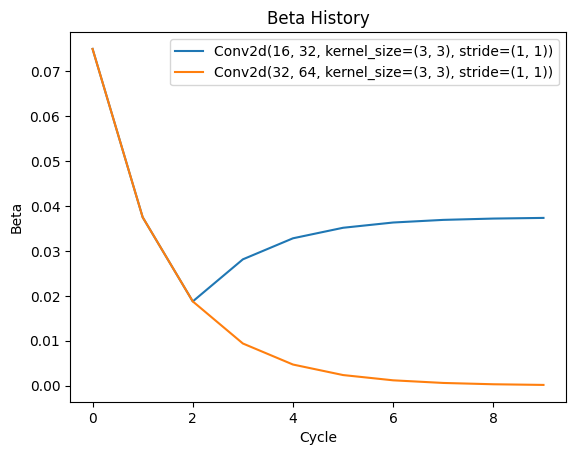


[OurCNN channel pruning, save]LR:0.0000|LOSS:0.01|ACC:99.11|PR_F:49.51|PR_P:52.19:   0%|       | 0/1876 [00:36<?, ?it/s]


Val accuracy: 99.11%


In [25]:
cycles = 5
prune = 0.5
lr = 0.015
momentum = 0.9
weight_decay = 1e-3
max_epoch = 2
savepath = '/content/drive/MyDrive/ECE570_AI/Project/group_channel_pruning_best_model.pth'
our_cnn = OurCNN()

loadpath_group = '/content/drive/MyDrive/ECE570_AI/Project/group_learning_best_model.pth'
state_dict = torch.load(loadpath_group)
filtered_state_dict = {k: v for k, v in state_dict[0].items() if k in our_cnn.state_dict()}

our_cnn = OurCNN()
our_cnn.load_state_dict(filtered_state_dict)
our_cnn.to(device)
# our_cnn.load_state_dict(filtered_state_dict, strict=False)



# #plot history
# plt.plot(beta_history)
# plt.xlabel('Cycle')
# plt.ylabel('Beta')
# plt.title('Beta History')
# plt.show()

print("="*80)
print("Starting pruning")
print("="*80)
result_dict_knee = {}
values = np.arange(0, 0.03,0.005)
# for beta in [0, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27]:
for beta in values:
    pruner = PruneWrapper(our_cnn,groups, 2)

    total_params = sum(p.numel() for p in our_cnn.parameters())
    # print(f'OurCNN has a total of {total_params} parameters')

    epoch_per_cycle = math.ceil(max_epoch / cycles)
    scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)

    flops, params, beta_history = pruner.initialize(prune, beta=0.15)
    bestset = {'acc':0, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
    print("="*80)
    print(f"Current beta: {beta}")
    if(beta != 0):
      pruner.beta = beta
    bar = tqdm(total=len(train_loader) * max_epoch, ncols=120)
    for epoch in range(max_epoch):
        our_cnn.train()
        for step, (images, labels) in enumerate(train_loader):

            optimizer.zero_grad()
            gpuimg = images.to(device)
            labels = labels.to(device)

            outputs = our_cnn(gpuimg)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            pruner.after_step()
            # bar.set_description("[" + "OurCNN channel pruning" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # bar.update()

        scheduler.step()
        our_cnn.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = our_cnn(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted.cpu() == labels).sum().item()
        acc = 100 * correct / total
        print()
        print(f"Val accuracy: {acc}%")
        our_cnn.train()

        if bestset['acc']<=acc:
            bestset = {'acc':acc, 'flops':flops, 'params':params, 'state_dict': copy.deepcopy(our_cnn.state_dict())}
            torch.save([bestset['state_dict'], bestset['acc']], savepath)
            bar.set_description("[" + "OurCNN channel pruning, save" + "]LR:%.4f|LOSS:%.2f|ACC:%.2f|PR_F:%.2f|PR_P:%.2f" % (get_lr(optimizer)[0], loss.item(), bestset['acc'], bestset['flops'], bestset['params']))
            # if(beta != 0):
            result_dict_knee[beta] = [bestset['acc'], bestset['flops'], bestset['params'], pruner.beta]
            # else:
              # result_dict[pruner.beta] = [bestset['acc'], bestset['flops'], bestset['params']]

        # prune a small portion of channels for each cycle
        # to prevent over-fitting and to remove dead channels
        if (epoch<max_epoch-1) and ((epoch+1)%epoch_per_cycle==0):
            our_cnn.load_state_dict(bestset['state_dict'])
            flops, params, beta_history_new=pruner.initialize(bestset['flops']/100+0.001)
            optimizer = torch.optim.SGD(our_cnn.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
            scheduler = CosineAnnealingLR(optimizer, epoch_per_cycle)
            print(f"beta_history_new: {beta_history_new}")
            for layer_name, betas in beta_history_new.items():
                plt.plot(betas, label=layer_name)  # Plot betas for each layer

            plt.xlabel('Cycle')
            plt.ylabel('Beta')
            plt.title('Beta History')
            plt.legend()  # Show legend to identify layers
            plt.show()

bar.close()

       Accuracy      FLOPS   Params   Beta
0.000     98.74  49.512341  52.1875  0.000
0.005     98.74  49.512341  52.1875  0.005
0.010     99.00  49.512341  52.1875  0.010
0.015     99.00  49.512341  52.1875  0.015
0.020     98.92  49.512341  52.1875  0.020
0.025     99.11  49.512341  52.1875  0.025


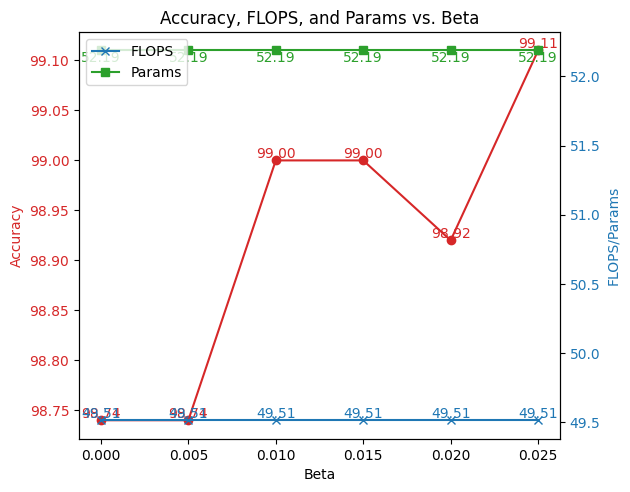

In [26]:
df = pd.DataFrame.from_dict(result_dict_knee, orient='index', columns=['Accuracy', 'FLOPS', 'Params', 'Beta'])
print(df)
betas = list(result_dict_knee.keys())
accuracies = [result_dict_knee[key][0] for key in betas]
flops = [result_dict_knee[key][1] for key in betas]
params = [result_dict_knee[key][2] for key in betas]

fig, ax1 = plt.subplots()

# Accuracy
color = 'tab:red'
ax1.set_xlabel('Beta')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(betas, accuracies, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Add data labels for Accuracy
for x, y in zip(betas, accuracies):
    ax1.text(x, y, f'{y:.2f}', ha='center', va='bottom', color=color)

# FLOPS and Params
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('FLOPS/Params', color=color)
ax2.plot(betas, flops, color=color, marker='x', label='FLOPS')
ax2.plot(betas, params, color='tab:green', marker='s', label='Params')
ax2.tick_params(axis='y', labelcolor=color)

# Add data labels for FLOPS and Params
for x, y in zip(betas, flops):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='bottom', color='tab:blue')
for x, y in zip(betas, params):
    ax2.text(x, y, f'{y:.2f}', ha='center', va='top', color='tab:green')  # Adjusted va for clarity

fig.tight_layout()
plt.title('Accuracy, FLOPS, and Params vs. Beta')
plt.legend(loc='upper left')
plt.show()

Pruning is more conservative than baseline. Accuracy has the same general trend. Less pruned in terms of FLOPS and params.